#**CHAPTER 10. FUTURES TREND PLUS CARRY**
---

##0.REFERENCE

https://chatgpt.com/share/698e5d49-197c-8012-a607-b9a9daa5e33c

##1.CONTEXT

**Introduction — Synthetic Futures Trend + Carry Laboratory**

**Scope and intent**  
This notebook is a mechanism-first laboratory for understanding how a trend-following futures book interacts with carry, regimes, and execution constraints when the entire market is generated synthetically and deterministically. The goal is not to “discover alpha” and it is not to approximate any single real futures market. The objective is to build disciplined intuition about the structural objects that dominate managed-futures style programs: persistence and breakage of trends, the economic meaning of carry, the geometry of exposure under risk constraints, and the way costs and liquidity can invert the apparent attractiveness of a signal. Every output is marked **Not verified** and the notebook is designed to be auditable and reproducible rather than persuasive.

**Economic context: futures as a financing-and-inventory system**  
Futures markets exist at the intersection of hedging demand, financing conditions, and inventory constraints. Unlike cash markets where “hold” implies funding and balance sheet, futures embed leverage mechanically through margining, and they embed financing economically through the forward price. This makes futures an ideal setting for a mechanism-first discussion of why a return stream can be decomposed into interpretable components. A stylized decomposition treats a futures return as the sum of (i) a directional price move, which is the object targeted by time-series trend, (ii) a carry or roll component, which is the object targeted by strategies sensitive to backwardation/contango and implied funding, and (iii) a residual shock component, which absorbs microstructure noise, regime shocks, and unmodeled influences. In real markets these components are not cleanly separable and can be state-dependent; nevertheless, the decomposition is useful as a teaching scaffold because it forces a researcher to ask which mechanism is being harvested and how it could fail.

**Why the mechanism matters: trend and carry are not the same trade**  
Trend and carry are often spoken about as if they are alternative “styles,” but mechanically they are different propositions. Trend depends on persistence: it requires that price changes exhibit a directional autocorrelation at the horizon used by the signal. Carry depends on the term structure of expected returns embedded in futures prices: in commodities it is linked to inventory and convenience yield; in rates it is linked to the shape of the yield curve; in FX it is linked to interest differentials; in equity index futures it is linked to funding and dividends. Both can produce returns in quiet regimes, and both can be punished in stress regimes, but their failure modes differ. Trend can fail when markets become choppy, when trends reverse violently, or when correlation compresses such that cross-sectional differentiation collapses. Carry can fail when funding conditions invert, when inventories rebuild abruptly, or when the risk premia embedded in the curve are repriced. The educational value of combining them is not diversification-by-slogan; it is to show that a portfolio rule must decide how to weight two mechanisms whose risk surfaces do not align.

**What the notebook demonstrates**  
The notebook implements a full research lifecycle for a **Futures Trend + Carry** policy: synthetic market construction with four regimes; explicit signal isolation and IC diagnostics; a trading engine that imposes turnover caps, leverage limits, volatility targeting, liquidity-aware costs, and drawdown gating; a stress suite that reruns the entire system under scenario perturbations; a parameter grid to map sensitivity of outcomes to key hyperparameters; and a Monte Carlo envelope to illustrate outcome dispersion under residual resampling. The deliverables are written every run, hashed, and bundled into a tamper-evident audit package. This makes the notebook resemble internal buy-side research infrastructure: the emphasis is on traceability, reproducibility, and mechanism clarity.

**Agentic structure: a closed-loop policy under constraints**  
Although the strategy is implemented as a rule-based policy, it is “agentic” in the practical sense that it is a closed-loop decision system. Each day the policy observes a state (signals, volatility, drawdown, liquidity conditions) and chooses an action (target weights). That action produces trades, trades incur costs, and realized PnL updates the state. In this loop, the policy is not free to implement the “ideal” portfolio implied by scores. It must respect a turnover cap and leverage constraint, it must scale exposure to maintain a volatility target, and it must reduce or eliminate risk when drawdowns or volatility exceed governance gates. This is the core mechanism-first lesson: a strategy is not just a signal; it is a signal embedded in a constrained control system.

**Curves and surfaces: where geometry emerges**  
In this laboratory, “surfaces” arise whenever a scalar objective depends on multiple state variables. The most important surfaces are execution and feasibility surfaces. Execution cost is modeled as a function of turnover and liquidity, including a convex impact term. This immediately creates a cost surface where incremental turnover becomes disproportionately expensive as liquidity deteriorates. Feasibility arises as a surface because leverage limits and volatility targeting couple exposure to realized volatility. The same ranking signal produces different attainable portfolios depending on the vol state: in calm regimes, the policy can scale gross; in volatile regimes, scaling compresses. Carry and trend themselves also form a surface: the combined score is an explicit blend of cross-sectional z-scores, which means that the influence of carry depends on its dispersion relative to trend. When dispersion collapses, the effective dimensionality of the opportunity set shrinks and the portfolio becomes more sensitive to correlated shocks.

**Execution realism: why cost can dominate theory**  
The notebook makes execution costs endogenous to the policy’s behavior. Turnover is not a reporting statistic; it is a control variable that interacts with signal responsiveness. A fast-reacting trend rule may improve responsiveness in idealized frictionless conditions while simultaneously increasing trading intensity in regimes where liquidity is impaired. When costs are convex, the trade-off is not linear: there can be a “capacity cliff” where small increases in turnover produce large increases in impact. In mechanism-first terms, a strategy is fragile when its payoff depends on being able to rotate quickly through positions at low cost, and robust when it can earn its return with modest turnover even under liquidity stress. This notebook is designed to make that fragility legible through explicit cost modeling, turnover diagnostics, and stress tests.

**Regime behavior: designed states to teach failure modes**  
The synthetic market includes four regimes: a risk-on trend regime, a risk-off crash regime, a carry-active inflation-like regime, and a choppy mean-reverting regime. These are not intended to match historical data; they are constructed to create interpretable perturbations. The crash regime increases correlation and volatility while impairing liquidity, which stress-tests the strategy’s assumption that cross-sectional ranking is actionable. The choppy regime reduces trend persistence and therefore targets the trend mechanism directly. The carry-active regime increases the drift of carry, illustrating how a carry-sensitive allocation can dominate a blended score when the curve premium is strong. The regime design turns the market into a laboratory of causal probes: you can ask not “does it work,” but “which mechanism is being rewarded, and under what state variables does it become infeasible?”

**No prediction framing: a controlled environment for structural reasoning**  
Nothing in this notebook should be interpreted as a forecast of real-world performance. The synthetic generator embeds assumptions about persistence, dispersion, and shock tails; changing those assumptions changes the nature of the market. That is a feature, not a bug. The correct use of this notebook is to interrogate how a strategy behaves when the world changes: when carry inverts, when trends break down, when liquidity disappears, when correlation compresses. The notebook’s governance artifacts exist to ensure that these investigations are reproducible and reviewable, and that the narrative remains disciplined: mechanisms first, evidence second, and decision-making only after independent verification.


##2.LIBRARIES AND ENVIRONMENT



**Objective**
Build an institutional, regulator-ready research notebook that implements a **Futures Trend + Carry** strategy in a **fully synthetic** multi-regime market, with execution realism, stress testing, parameter sensitivity, Monte Carlo robustness, fragility scoring, governance tiering, and a tamper-evident audit bundle.

**Synthetic-Only Disclaimer**
All data in this notebook is **synthetic** and generated deterministically from the configuration seed. Outputs are **Not verified** and for research governance demonstration only. This is **not** investment advice and does not claim real-world profitability.

**10 Trade-Logic Elements (Implemented)**
1) **Universe definition:** Multi-asset synthetic futures (rates, FX, equity index, commodities), N contracts, daily sampling.  
2) **Primary signal:** Time-series trend (multi-horizon momentum blend).  
3) **Secondary filter(s):** Carry (synthetic roll yield / implied funding) + regime-aware risk gate (volatility + drawdown + liquidity).  
4) **Entry rule:** Rank by combined score = w_trend * z(trend) + w_carry * z(carry); go long top K, short bottom K.  
5) **Exit rule:** Daily rebalance with turnover cap; forced de-risk on drawdown stop or vol blowout gate.  
6) **Position direction:** Long/short cross-sectional futures book (dollar-neutral gross exposure, vol-targeted).  
7) **Holding horizon:** 1-day step with persistent positions under turnover and gate constraints.  
8) **Portfolio construction:** Inverse-vol risk parity within long and short sleeves; gross leverage scaled to target volatility.  
9) **Risk controls:** Vol targeting, max leverage, turnover cap, liquidity-aware costs, drawdown stop, regime shock multipliers.  
10) **Governance gates:** Determinism certification, artifact hashing, fragility scoring, model-risk tier, deployment classification.


In [1]:
# GOVERNANCE SETUP (Cell 2) — imports, deterministic config, helpers, root artifacts (production-grade)

import os, sys, json, math, random, hashlib, platform, zipfile, datetime, statistics
import matplotlib.pyplot as plt

# -----------------------------
# Deterministic CONFIG
# -----------------------------
CONFIG = {
    "strategy_id": 10,
    "strategy_name": "Futures Trend + Carry",
    "seed": 170010,                      # fixed deterministic seed
    "n_assets": 18,                      # synthetic futures contracts
    "n_days": 900,                       # trading days
    "warmup": 80,                        # signal warmup
    "rebalance_every": 1,                # daily
    "top_k": 4,
    "vol_lookback": 40,
    "trend_lookbacks": [20, 60, 120],    # multi-horizon trend blend
    "trend_weights": [0.5, 0.3, 0.2],
    "carry_weight": 0.45,                # combined score weight for carry
    "trend_weight": 0.55,                # combined score weight for trend
    "target_vol_annual": 0.12,           # portfolio target vol
    "max_gross_leverage": 3.0,
    "turnover_cap": 0.55,                # cap on daily turnover fraction of gross
    "dd_stop": 0.18,                     # drawdown stop (peak-to-trough)
    "gate_vol_mult": 2.2,                # gate if realized vol > mult * target
    "tc_bps": 0.8,                       # base transaction cost (bps of notional traded)
    "slip_bps": 0.6,                     # base slippage (bps)
    "impact_k": 8.0e-4,                  # convex impact coefficient
    "impact_exp": 1.35,                  # convexity exponent
    "liquidity_floor": 0.25,             # minimum liquidity scaler
    "stress_generic": 4,
    "stress_specific": 2,
    "sensitivity": {
        "trend_lb_short": [15, 20, 30],
        "carry_weight": [0.25, 0.45, 0.65]
    },
    "monte_carlo": {
        "n_sims": 220,                   # >=200
        "resid_bootstrap_block": 5       # block bootstrap length
    },
    "version": {
        "notebook_schema": "StrategiesUnderGovernance.v1",
        "verification_status_required": "Not verified"
    }
}

# -----------------------------
# Deterministic seed control
# -----------------------------
random.seed(CONFIG["seed"])

# -----------------------------
# Output directories
# -----------------------------
ROOT_FILES = ["run_manifest.json", "prompts_log.jsonl", "risk_log.json"]
DELIV_DIR = "deliverables"
os.makedirs(DELIV_DIR, exist_ok=True)

# -----------------------------
# UTC timestamp (timezone-aware)
# -----------------------------
def utc_now_iso():
    return datetime.datetime.now(datetime.timezone.utc).isoformat()

# -----------------------------
# JSON artifact template (mandatory)
# -----------------------------
def artifact_template():
    return {
        "verification_status": "Not verified",
        "facts_provided": {},
        "assumptions": {},
        "open_items": [],
        "analysis": {},
        "outputs": {}
    }

def write_json(path, payload):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, sort_keys=True)

def append_jsonl(path, obj):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(obj, sort_keys=True) + "\n")

def sha256_bytes(b):
    h = hashlib.sha256()
    h.update(b)
    return h.hexdigest()

def sha256_file(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def safe_div(a, b, default=0.0):
    if b == 0:
        return default
    return a / b

def clamp(x, lo, hi):
    return lo if x < lo else (hi if x > hi else x)

# -----------------------------
# Run manifest (production-grade provenance)
# -----------------------------
run_id = sha256_bytes((utc_now_iso() + str(CONFIG["seed"]) + str(CONFIG["n_days"]) + CONFIG["strategy_name"]).encode("utf-8"))[:16]
config_hash = sha256_bytes(json.dumps(CONFIG, sort_keys=True).encode("utf-8"))

env_fingerprint = {
    "python_version": sys.version.replace("\n", " "),
    "platform": platform.platform(),
    "executable": sys.executable,
    "utc_timestamp": utc_now_iso()
}

run_manifest = artifact_template()
run_manifest["facts_provided"] = {
    "strategy_id": CONFIG["strategy_id"],
    "strategy_name": CONFIG["strategy_name"],
    "data_policy": "Synthetic only",
    "no_pandas": True,
    "deterministic_seed": CONFIG["seed"],
    "exact_cells": 10
}
run_manifest["analysis"] = {
    "run_id": run_id,
    "config_hash_sha256": config_hash,
    "environment": env_fingerprint,
    "schema": CONFIG["version"]["notebook_schema"]
}
write_json("run_manifest.json", run_manifest)

# -----------------------------
# prompts_log.jsonl (append-only)
# -----------------------------
prompt_record = {
    "utc_timestamp": utc_now_iso(),
    "run_id": run_id,
    "config_hash_sha256": config_hash,
    "prompt_summary": "Generate governed synthetic-first lab for Strategy 10 Futures Trend + Carry with stress tests, sensitivity, Monte Carlo, fragility scoring, and tamper-evident audit bundle.",
    "redaction_note": "No external data; no confidential inputs."
}
append_jsonl("prompts_log.jsonl", prompt_record)

# -----------------------------
# risk_log.json (initial)
# -----------------------------
risk_log = artifact_template()
risk_log["analysis"] = {
    "run_id": run_id,
    "capability_boundary": "Research-only synthetic laboratory",
    "primary_risks": [
        "Model risk: synthetic assumptions may not map to real markets",
        "Execution risk: impact and liquidity are stylized proxies",
        "Over-interpretation risk: outputs are Not verified",
        "Regime specification risk: regimes are designed, not inferred"
    ],
    "controls": [
        "Deterministic seed + config hashing",
        "Stress suite reruns full engine under perturbations",
        "Monte Carlo envelope (>=200)",
        "Artifact hashing registry + master bundle hash",
        "Explicit governance tier and deployment status"
    ],
    "human_review_required": True
}
write_json("risk_log.json", risk_log)

print("Governance initialized.")
print("run_id:", run_id)
print("config_hash_sha256:", config_hash)


Governance initialized.
run_id: 9fc73deb39aaabce
config_hash_sha256: f4925668074e617fabd147c3bca3f9a5be58a64072ac45570180b79ea20ae128


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

**Cell 3 — Synthetic Market Generator (Futures Regimes, Components, and Economic Structure)**

**Purpose of the cell**  
Cell 3 constructs the synthetic futures market that the rest of the notebook treats as the “world.” The market is not a dataset; it is a structural object. The entire downstream research pipeline—signals, backtest, costs, stresses, fragility—only makes sense if the environment has economically interpretable moving parts. This cell therefore builds a multi-asset universe with heterogeneous asset classes, simulates a regime path with persistence, and generates daily returns as the sum of explicit components: a trend component, a carry component, a residual component, and occasional crash shocks. It also produces regime-level state variables—volatility, correlation, liquidity—that later appear as constraints and stress multipliers.

**Market mechanism being modeled**  
The central mechanism is the decomposition of futures returns into drivers aligned with professional intuition. Trend stands for directional persistence and macro drift. Carry stands for roll yield or implied financing embedded in the forward curve. The residual stands for shocks and microstructure noise. Because futures are leveraged instruments, volatility and liquidity matter disproportionately: the same nominal position can have radically different risk and execution feasibility under different regime states. This cell models that by allowing regimes to alter volatility, correlation (cross-sectional synchronization), and liquidity (the cost of trading).

**Features being constructed**  
The cell constructs a universe with class tags (rates, FX, equity index, commodities) to enforce structural heterogeneity. Each class has its own carry mean and volatility and its own sensitivity to crash shocks. A regime path is generated with a transition structure that creates persistence. For each day, regime specs set a volatility level, a correlation proxy, and a liquidity scaler. Returns are then synthesized by combining: (i) a persistent trend state updated each day, (ii) a slowly evolving carry state with regime drift, and (iii) a residual shock term scaled by volatility and correlation. Crash regimes introduce fat-tail events that propagate differently by asset class.

**Environment logic and agent relevance**  
This environment is designed to reward and punish the two mechanisms the strategy tries to harvest. Risk-on trend states should make trend signals meaningful; choppy states should erode them. Carry-active regimes should increase the informativeness of carry differentials; carry inversion stresses will later attack that premise explicitly. Liquidity and correlation are not decorations: they determine whether cross-sectional ranking remains actionable and whether execution costs explode when the agent attempts to rotate the book.

**Learning objective**  
The learning objective is to force the practitioner to treat “the market” as an explicit set of causal levers. By separating components and regimes, the notebook turns strategy evaluation into a controlled experiment: you can perturb trend persistence, carry drift, volatility, correlation, and liquidity independently and observe how the policy fails or survives. That discipline is the foundation of mechanism-first research.


###3.2.CODE AND IMPLEMENTATION

In [2]:
# SYNTHETIC MARKET GENERATOR (Cell 3) — multi-regime, factor-aware futures returns with decomposed components

def make_universe(n_assets):
    # Asset classes for structural heterogeneity
    classes = (["Rates"] * 5) + (["FX"] * 5) + (["EquityIdx"] * 4) + (["Commod"] * 4)
    classes = classes[:n_assets]
    tickers = []
    for i in range(n_assets):
        tickers.append(f"FUT_{classes[i][:3].upper()}_{i:02d}")
    return tickers, classes

def regime_path(n_days):
    # 4 regimes with persistence (Markov-ish, but deterministic via RNG)
    # 0: Risk-on Trend, 1: Risk-off Crash, 2: Inflation/Carry-Active, 3: Choppy Mean-Revert
    trans = {
        0: [(0, 0.90), (2, 0.06), (3, 0.03), (1, 0.01)],
        1: [(1, 0.78), (3, 0.12), (0, 0.08), (2, 0.02)],
        2: [(2, 0.86), (0, 0.08), (3, 0.04), (1, 0.02)],
        3: [(3, 0.84), (0, 0.10), (2, 0.04), (1, 0.02)]
    }
    path = [0]
    for t in range(1, n_days):
        r = path[-1]
        u = random.random()
        cum = 0.0
        nxt = r
        for (rr, p) in trans[r]:
            cum += p
            if u <= cum:
                nxt = rr
                break
        path.append(nxt)
    return path

def class_params(asset_class):
    # Structural differences: carry prevalence, trend responsiveness, shock sensitivity
    if asset_class == "Rates":
        return {"carry_mu": 0.00010, "carry_sigma": 0.00018, "trend_beta": 0.55, "shock_beta": 0.75}
    if asset_class == "FX":
        return {"carry_mu": 0.00008, "carry_sigma": 0.00022, "trend_beta": 0.50, "shock_beta": 0.60}
    if asset_class == "EquityIdx":
        return {"carry_mu": 0.00003, "carry_sigma": 0.00015, "trend_beta": 0.75, "shock_beta": 1.05}
    # Commodities
    return {"carry_mu": 0.00006, "carry_sigma": 0.00028, "trend_beta": 0.65, "shock_beta": 0.95}

def gen_market(CONFIG):
    nA = CONFIG["n_assets"]
    nD = CONFIG["n_days"]
    tickers, classes = make_universe(nA)
    regs = regime_path(nD)

    # regime-level factors
    # Each day: common trend factor, carry regime drift, vol level, corr compression, liquidity scaler
    reg_specs = {
        0: {"trend_mu": 0.00035, "carry_drift": 0.00003, "vol": 0.010, "corr": 0.25, "liq": 1.00, "crash": 0.0},
        1: {"trend_mu": -0.00055, "carry_drift": -0.00004, "vol": 0.025, "corr": 0.70, "liq": 0.45, "crash": 1.0},
        2: {"trend_mu": 0.00020, "carry_drift": 0.00010, "vol": 0.012, "corr": 0.35, "liq": 0.85, "crash": 0.0},
        3: {"trend_mu": 0.00000, "carry_drift": 0.00000, "vol": 0.014, "corr": 0.45, "liq": 0.75, "crash": 0.0}
    }

    # Precompute a correlated common shock per day to induce correlation
    # Corr implemented via: r = sqrt(corr)*common + sqrt(1-corr)*idio
    common_shock = [random.gauss(0.0, 1.0) for _ in range(nD)]

    # Asset-level state
    # carry_series: slowly varying roll yield proxy
    carry = [[0.0] * nD for _ in range(nA)]
    trend_component = [[0.0] * nD for _ in range(nA)]
    carry_component = [[0.0] * nD for _ in range(nA)]
    resid_component = [[0.0] * nD for _ in range(nA)]
    ret = [[0.0] * nD for _ in range(nA)]
    liquidity = [0.0] * nD
    corr_level = [0.0] * nD
    vol_level = [0.0] * nD

    # Initialize carry states
    carry_state = []
    for i in range(nA):
        p = class_params(classes[i])
        carry_state.append(p["carry_mu"] + random.gauss(0.0, p["carry_sigma"]))

    # Trend state: persistent drift term for each asset, which flips/changes by regime
    trend_state = [0.0] * nA

    # Generate
    for t in range(nD):
        rg = regs[t]
        spec = reg_specs[rg]
        liquidity[t] = max(CONFIG["liquidity_floor"], spec["liq"])
        corr_level[t] = spec["corr"]
        vol_level[t] = spec["vol"]

        # regime common trend driver
        common_trend = spec["trend_mu"] + 0.25 * spec["vol"] * common_shock[t]
        # crash shock (fat tail)
        crash_jolt = 0.0
        if spec["crash"] > 0.5 and random.random() < 0.06:
            crash_jolt = random.gauss(-0.06, 0.03)  # large negative shock day

        for i in range(nA):
            p = class_params(classes[i])

            # carry evolves slowly, regime-drifted (captures carry cycle)
            carry_state[i] = 0.995 * carry_state[i] + 0.005 * (p["carry_mu"] + spec["carry_drift"]) + random.gauss(0.0, p["carry_sigma"] * 0.06)
            carry[i][t] = carry_state[i]

            # trend_state: in choppy regime mean-reverts to ~0; in other regimes follows common trend
            if rg == 3:
                trend_state[i] = 0.85 * trend_state[i] + random.gauss(0.0, spec["vol"] * 0.05)
            else:
                trend_state[i] = 0.92 * trend_state[i] + p["trend_beta"] * common_trend + random.gauss(0.0, spec["vol"] * 0.04)

            # correlated residual
            idio = random.gauss(0.0, 1.0)
            z = math.sqrt(max(0.0, corr_level[t])) * common_shock[t] + math.sqrt(max(0.0, 1.0 - corr_level[t])) * idio

            # components
            trend_component[i][t] = trend_state[i]
            carry_component[i][t] = carry[i][t]
            resid_component[i][t] = spec["vol"] * (0.55 * z)  # idio+common residual

            # crash transmission is class dependent
            shock = p["shock_beta"] * crash_jolt

            # total return
            ret[i][t] = trend_component[i][t] + carry_component[i][t] + resid_component[i][t] + shock

    market = {
        "tickers": tickers,
        "classes": classes,
        "regimes": regs,
        "ret": ret,
        "trend_component": trend_component,
        "carry_component": carry_component,
        "resid_component": resid_component,
        "liquidity": liquidity,
        "corr_level": corr_level,
        "vol_level": vol_level
    }
    return market

market = gen_market(CONFIG)

# Update run_manifest with market spec summary
rm = json.load(open("run_manifest.json", "r", encoding="utf-8"))
rm["analysis"]["synthetic_market"] = {
    "n_assets": CONFIG["n_assets"],
    "n_days": CONFIG["n_days"],
    "n_regimes": 4,
    "regime_labels": {
        "0": "Risk-on Trend",
        "1": "Risk-off Crash",
        "2": "Inflation/Carry-Active",
        "3": "Choppy Mean-Revert"
    },
    "universe_classes": {c: market["classes"].count(c) for c in set(market["classes"])}
}
write_json("run_manifest.json", rm)

print("Synthetic market generated.")
print("Universe sample:", market["tickers"][:5])


Synthetic market generated.
Universe sample: ['FUT_RAT_00', 'FUT_RAT_01', 'FUT_RAT_02', 'FUT_RAT_03', 'FUT_RAT_04']


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

**Cell 4 — Signal Computation (Trend + Carry Isolation and Skill Diagnostics)**

**Purpose of the cell**  
Cell 4 translates the market’s components into the information objects that the policy will act upon. A mechanism-first notebook cannot allow signals to be implicit or magical; the point is to show exactly what “trend” and “carry” mean in the environment, how they are normalized, and how their cross-sectional dispersion evolves. This cell computes a multi-horizon trend proxy via blended cumulative returns, computes a carry proxy directly from the synthetic carry component, and then forms a combined score using cross-sectional z-scores. It also computes an Information Coefficient (IC) series that evaluates whether today’s scores have cross-sectional alignment with next-day returns.

**Market mechanism being modeled**  
The mechanism here is separation of economic channels. Trend is operationalized as persistence over multiple lookbacks, reflecting the fact that time-series momentum is horizon-dependent. Carry is treated as a contemporaneous premium-like feature—analogous to roll yield or funding differential—whose dispersion across contracts creates a cross-sectional opportunity set. The combined score is not a simple sum of raw values; it is a sum of standardized cross-sectional deviations, which makes the policy sensitive to relative opportunity rather than absolute levels.

**Features being constructed**  
Several key features are built. First, the trend signal is a weighted blend across horizons, which prevents the strategy from being narrowly tuned to a single autocorrelation scale. Second, carry is introduced as a parallel standardized channel, allowing the portfolio to express curve premia even when directional trend is muted. Third, the combined score uses cross-sectional z-scores to control for level shifts and to ensure comparability across asset classes. Finally, the IC series is computed as a rank-correlation proxy between signal at time t and next-day return, creating a diagnostic for whether the cross-sectional ranking has any structural “skill” under the synthetic assumptions.

**Policy behavior linkage**  
This cell defines what the agent “sees.” The agent is not allowed to observe regimes directly; it observes the world through the lens of signals whose behavior changes by regime. In risk-on regimes, trend persistence should produce coherent rankings; in choppy regimes, rankings should degrade. In carry-active regimes, carry dispersion should increase the importance of the carry channel. The IC series is not used to trade in this notebook, but it is critical for governance: it provides an internal consistency check linking the signal to the outcomes it is supposed to organize.

**Execution and governance relevance**  
Standardization and IC tracking matter because execution constraints make “weak signals” expensive. If rankings are unstable, turnover rises, costs rise, and the policy’s realized outcomes can deteriorate even if average raw signal appears positive. This cell therefore provides the statistical foundation that later diagnostics and fragility scoring will interrogate: if IC collapses under stress, that is a mechanism-level failure, not a parameter inconvenience.

**Learning objective**  
The objective is to teach signal literacy: a strategy is only as interpretable as its signal definition, and signal definitions must be paired with diagnostics that survive outside backtest PnL. IC is a bridge between economic hypothesis and realized outcomes, and cross-sectional z-scoring is a discipline that prevents naive mixing of incomparable measures.


###4.2.CODE AND IMPLEMENTATION

In [3]:
# SIGNAL COMPUTATION (Cell 4) — trend + carry signals, cross-sectional z-scores, IC tracking

def mean(xs):
    return statistics.mean(xs) if xs else 0.0

def stdev(xs):
    if len(xs) < 2:
        return 0.0
    return statistics.pstdev(xs)

def zscore_cross_section(xlist):
    m = mean(xlist)
    s = stdev(xlist)
    if s == 0:
        return [0.0 for _ in xlist]
    return [(x - m) / s for x in xlist]

def rolling_sum(series, t, lb):
    # sum from t-lb+1..t inclusive
    if t - lb + 1 < 0:
        return None
    s = 0.0
    for k in range(t - lb + 1, t + 1):
        s += series[k]
    return s

def compute_signals(CONFIG, market):
    nA = CONFIG["n_assets"]
    nD = CONFIG["n_days"]
    warm = CONFIG["warmup"]
    trend_lbs = CONFIG["trend_lookbacks"]
    tw = CONFIG["trend_weights"]

    # signal matrices
    trend_sig = [[0.0] * nD for _ in range(nA)]
    carry_sig = [[0.0] * nD for _ in range(nA)]
    combo_sig = [[0.0] * nD for _ in range(nA)]

    # IC tracking (cross-sectional rank correlation approx via Pearson on ranks)
    ic = [0.0] * nD
    ic_roll = [0.0] * nD

    # for IC: signal at t predicts next-day returns at t+1
    for t in range(nD):
        # carry signal is instantaneous carry component (stylized roll yield / funding)
        for i in range(nA):
            carry_sig[i][t] = market["carry_component"][i][t]

        # trend signal is blended cumulative return over multiple lookbacks
        for i in range(nA):
            if t < warm:
                trend_sig[i][t] = 0.0
                continue
            acc = 0.0
            wsum = 0.0
            for w, lb in zip(tw, trend_lbs):
                rs = rolling_sum(market["ret"][i], t, lb)
                if rs is None:
                    continue
                acc += w * rs
                wsum += w
            trend_sig[i][t] = safe_div(acc, wsum, 0.0)

        # cross-sectional z-score then combine
        if t >= warm:
            trend_x = [trend_sig[i][t] for i in range(nA)]
            carry_x = [carry_sig[i][t] for i in range(nA)]
            zt = zscore_cross_section(trend_x)
            zc = zscore_cross_section(carry_x)
            for i in range(nA):
                combo = CONFIG["trend_weight"] * zt[i] + CONFIG["carry_weight"] * zc[i]
                combo_sig[i][t] = combo

        # IC at t uses combo at t and returns at t+1
        if t >= warm and t < nD - 1:
            svec = [combo_sig[i][t] for i in range(nA)]
            rvec = [market["ret"][i][t + 1] for i in range(nA)]
            # rank transform to reduce outlier sensitivity
            def ranks(v):
                idx = list(range(len(v)))
                idx.sort(key=lambda k: v[k])
                rk = [0] * len(v)
                for j, k in enumerate(idx):
                    rk[k] = j + 1
                return rk
            rs = ranks(svec)
            rr = ranks(rvec)
            # Pearson correlation of ranks (Spearman proxy)
            ms = mean(rs); mr = mean(rr)
            cov = 0.0; vs = 0.0; vr = 0.0
            for a in range(nA):
                ds = rs[a] - ms
                dr = rr[a] - mr
                cov += ds * dr
                vs += ds * ds
                vr += dr * dr
            ic[t] = safe_div(cov, math.sqrt(vs * vr), 0.0)

        # rolling IC (60d)
        if t >= warm + 60:
            window = [ic[k] for k in range(t - 59, t + 1)]
            ic_roll[t] = mean(window)

    signal_pack = {
        "trend_sig": trend_sig,
        "carry_sig": carry_sig,
        "combo_sig": combo_sig,
        "ic": ic,
        "ic_roll": ic_roll
    }
    return signal_pack

signals = compute_signals(CONFIG, market)

# Signal matrix artifact (compact: store last 200 days for audit practicality)
sig_art = artifact_template()
sig_art["analysis"] = {
    "run_id": run_id,
    "signal_definitions": {
        "trend": "Multi-horizon cumulative return blend (TSMOM proxy)",
        "carry": "Synthetic roll yield / implied funding proxy",
        "combo": "Cross-sectional z(trend) and z(carry) linear blend"
    },
    "ic_definition": "Spearman proxy via Pearson correlation of cross-sectional ranks (signal_t vs return_{t+1})",
    "storage_policy": "Store last 200 days to bound artifact size; full series reproducible from seed/config."
}
lastN = 200
nD = CONFIG["n_days"]
start = max(0, nD - lastN)
sig_art["outputs"] = {
    "tickers": market["tickers"],
    "window_start_index": start,
    "window_end_index": nD - 1,
    "combo_sig_tail": [[signals["combo_sig"][i][t] for t in range(start, nD)] for i in range(CONFIG["n_assets"])],
    "ic_tail": [signals["ic"][t] for t in range(start, nD)],
    "ic_roll_tail": [signals["ic_roll"][t] for t in range(start, nD)]
}
write_json(os.path.join(DELIV_DIR, "signal_matrix.json"), sig_art)

print("Signals computed. IC sample:", signals["ic"][CONFIG["warmup"]+5:CONFIG["warmup"]+10])


Signals computed. IC sample: [0.2260061919504644, 0.11042311661506708, 0.12693498452012383, 0.07327141382868937, 0.18885448916408668]


##5.TRADING ENGINE

###5.1.OVERVIEW

**Cell 5 — Trading Engine (Constrained Policy, Execution Costs, and Attribution)**

**Purpose of the cell**  
Cell 5 is the heart of the laboratory: it converts signals into actions under constraints and produces the realized PnL stream. In mechanism-first work, the trading engine is where the strategy’s claim meets feasibility. This cell implements portfolio construction, risk controls, execution realism, and attribution decomposition. The output is not only an equity curve; it is a full set of state series—turnover, leverage, exposure, costs—and decomposed returns (trend-driven, carry-driven, residual-driven) that allow the researcher to interpret what the policy is actually harvesting.

**Market mechanism being modeled**  
The mechanism is a cross-sectional managed-futures book that expresses both trend and carry. The policy ranks contracts by a combined score and builds a long sleeve in the top ranks and a short sleeve in the bottom ranks. Within sleeves, weights are constructed via inverse volatility to approximate risk parity. This creates a structural mapping from signal dispersion to position concentration: when dispersion is weak, differentiation is weak and positions become more fragile to noise; when dispersion is strong, the book is more decisively expressed.

**Execution modeling: why constraints are first-class objects**  
Execution realism is encoded through three interacting features. First, the engine computes turnover and enforces a turnover cap by interpolating from current to desired weights. This models operational constraints and acknowledges that portfolios cannot instantaneously jump to new targets. Second, transaction costs and slippage are charged proportional to traded notional. Third, a convex impact term penalizes trading intensity more than linearly, and all costs are amplified when liquidity is low. This makes liquidity a structural state variable: in stress regimes, the same signal change produces higher realized costs.

**Risk controls and gates**  
Volatility targeting scales exposure to a target risk level, while a max gross leverage bound prevents unconstrained scaling in calm periods. Drawdown and volatility gates can force the strategy to de-risk when survival constraints are threatened. These gates are not optional; they encode governance and capital preservation logic. They also create a feedback loop: gating changes trading behavior, trading behavior changes costs, and costs change equity and thus gating triggers.

**Attribution decomposition**  
Because the synthetic generator provides explicit components, the engine can compute component-level PnL: how much of the portfolio return is attributable to trend, carry, residual shocks, and costs. This is crucial: it prevents the common interpretive error of treating a positive equity curve as evidence of “trend following” when in fact carry or residual drift might dominate. In an institutional context, attribution is a model risk control because it reveals unintended exposures.

**Learning objective**  
The learning objective is to show that the agent’s intelligence is not only in ranking signals but in surviving constraints. A strategy that is profitable in frictionless arithmetic can be fragile when turnover, liquidity, and convex costs are introduced. This cell makes that fragility visible and measurable.


###5.2.CODE AND IMPLEMENTATION

In [4]:
# TRADING ENGINE (Cell 5) — execution realism, turnover cap, vol targeting, attribution decomposition

def ewma_vol(returns, t, lb):
    if t <= 0:
        return 0.0
    start = max(0, t - lb + 1)
    xs = returns[start:t+1]
    if len(xs) < 2:
        return 0.0
    # EWMA with lambda tuned to lb (approx)
    lam = math.exp(math.log(0.5) / max(1.0, lb / 2.0))
    w = 1.0
    sw = 0.0
    s2 = 0.0
    for x in reversed(xs):
        s2 += w * (x * x)
        sw += w
        w *= lam
    return math.sqrt(safe_div(s2, sw, 0.0))

def backtest_engine(CONFIG, market, signals, override=None):
    # override can modify market components or config weights for stress tests/sensitivity
    cfg = json.loads(json.dumps(CONFIG))
    mkt = market
    sig = signals

    if override:
        # shallow overrides for cfg
        for k, v in override.get("config_updates", {}).items():
            cfg[k] = v
        # component overrides
        comp = override.get("component_updates", {})
        if comp:
            # copy-on-write for affected components
            mkt = dict(market)
            for ck, newv in comp.items():
                mkt[ck] = newv
        # signal overrides
        sig_upd = override.get("signal_updates", {})
        if sig_upd:
            sig = dict(signals)
            for sk, newv in sig_upd.items():
                sig[sk] = newv

    nA = cfg["n_assets"]
    nD = cfg["n_days"]
    warm = cfg["warmup"]
    topk = cfg["top_k"]
    vol_lb = cfg["vol_lookback"]

    # state
    w = [0.0] * nA  # weights (signed), gross scaled later
    equity = [1.0] * nD
    dd = [0.0] * nD
    turnover = [0.0] * nD
    gross_lev = [0.0] * nD
    net_exp = [0.0] * nD
    pnl = [0.0] * nD

    # attribution
    pnl_trend = [0.0] * nD
    pnl_carry = [0.0] * nD
    pnl_resid = [0.0] * nD
    costs = [0.0] * nD

    # rolling Sharpe
    roll_sharpe = [0.0] * nD

    # position history for audit (store tail later)
    pos_hist = [[0.0] * nD for _ in range(nA)]

    peak = 1.0
    gated = False

    # helper to compute inv-vol weights
    def inv_vol_weights(indices, t):
        vols = []
        for i in indices:
            # realized vol proxy using total returns of asset i
            v = 0.0
            if t > 2:
                start = max(0, t - vol_lb + 1)
                xs = [mkt["ret"][i][k] for k in range(start, t+1)]
                v = stdev(xs)
            vols.append(max(1e-6, v))
        inv = [1.0 / v for v in vols]
        s = sum(inv)
        if s == 0:
            return [0.0 for _ in inv]
        return [x / s for x in inv]

    # portfolio vol targeting using realized portfolio returns
    def scale_to_target(port_ret_hist, t):
        if t < warm + 5:
            return 1.0
        rv = ewma_vol(port_ret_hist, t-1, vol_lb)
        daily_target = cfg["target_vol_annual"] / math.sqrt(252.0)
        if rv <= 1e-10:
            return 1.0
        return clamp(daily_target / rv, 0.0, cfg["max_gross_leverage"])

    for t in range(nD):
        if t == 0:
            for i in range(nA):
                pos_hist[i][t] = 0.0
            continue

        # compute current drawdown from peak
        peak = max(peak, equity[t-1])
        dd[t-1] = safe_div((peak - equity[t-1]), peak, 0.0)

        # risk gate: drawdown stop or vol blowout
        if dd[t-1] > cfg["dd_stop"]:
            gated = True
        # realized portfolio vol blowout gate
        if t > warm + 20:
            rv = ewma_vol(pnl, t-1, vol_lb)
            daily_target = cfg["target_vol_annual"] / math.sqrt(252.0)
            if rv > cfg["gate_vol_mult"] * daily_target:
                gated = True

        # desired weights
        w_des = [0.0] * nA

        if t >= warm and (not gated) and ((t % cfg["rebalance_every"]) == 0):
            scores = [sig["combo_sig"][i][t-1] for i in range(nA)]
            idx = list(range(nA))
            idx.sort(key=lambda k: scores[k])

            short_idx = idx[:topk]
            long_idx = idx[-topk:]

            # within-sleeve risk parity (inverse vol)
            wl = inv_vol_weights(long_idx, t-1)
            ws = inv_vol_weights(short_idx, t-1)

            for j, i in enumerate(long_idx):
                w_des[i] += wl[j]
            for j, i in enumerate(short_idx):
                w_des[i] -= ws[j]

            # gross normalize to 1.0 before scaling
            g = sum(abs(x) for x in w_des)
            if g > 0:
                w_des = [x / g for x in w_des]
        else:
            # if gated, target zero; else hold with decay to reduce turnover in quiet non-rebalance steps
            if gated:
                w_des = [0.0] * nA
            else:
                w_des = w[:]  # hold

        # apply turnover cap: interpolate between w and w_des
        dw = [w_des[i] - w[i] for i in range(nA)]
        to = 0.5 * sum(abs(x) for x in dw)  # turnover in weights (L1/2)
        if to > cfg["turnover_cap"] and to > 1e-12:
            frac = cfg["turnover_cap"] / to
            w_adj = [w[i] + frac * dw[i] for i in range(nA)]
        else:
            w_adj = w_des

        # vol-target scaling
        port_ret_hist = pnl
        scale = scale_to_target(port_ret_hist, t)
        w_scaled = [scale * x for x in w_adj]

        # leverage clamp
        gross = sum(abs(x) for x in w_scaled)
        if gross > cfg["max_gross_leverage"]:
            s = cfg["max_gross_leverage"] / gross
            w_scaled = [s * x for x in w_scaled]
            gross = cfg["max_gross_leverage"]

        # execution costs: base bps + slippage + convex impact, scaled by turnover and liquidity
        # Notional traded ~ turnover in weights; liquidity decreases amplify costs
        liq = max(cfg["liquidity_floor"], mkt["liquidity"][t])
        traded = 0.5 * sum(abs(w_scaled[i] - w[i]) for i in range(nA))
        base_cost = (cfg["tc_bps"] + cfg["slip_bps"]) * 1e-4 * traded
        impact = cfg["impact_k"] * ((max(0.0, traded) / max(1e-6, liq)) ** cfg["impact_exp"])
        cost_t = (base_cost + impact) / max(1e-6, liq)

        # portfolio return decomposition
        r_tr = 0.0
        r_ca = 0.0
        r_re = 0.0
        for i in range(nA):
            r_tr += w_scaled[i] * mkt["trend_component"][i][t]
            r_ca += w_scaled[i] * mkt["carry_component"][i][t]
            r_re += w_scaled[i] * (mkt["resid_component"][i][t])

        r_tot = r_tr + r_ca + r_re - cost_t

        pnl[t] = r_tot
        pnl_trend[t] = r_tr
        pnl_carry[t] = r_ca
        pnl_resid[t] = r_re
        costs[t] = cost_t

        equity[t] = equity[t-1] * (1.0 + r_tot)
        turnover[t] = traded
        gross_lev[t] = sum(abs(x) for x in w_scaled)
        net_exp[t] = sum(w_scaled)

        w = w_scaled[:]
        for i in range(nA):
            pos_hist[i][t] = w[i]

        # rolling Sharpe (63d)
        if t >= warm + 63:
            window = pnl[t-62:t+1]
            mu = mean(window)
            sd = stdev(window)
            roll_sharpe[t] = safe_div(mu, sd, 0.0) * math.sqrt(252.0)

    # finalize dd series
    peak = 1.0
    for t in range(nD):
        peak = max(peak, equity[t])
        dd[t] = safe_div((peak - equity[t]), peak, 0.0)

    bt = {
        "equity": equity,
        "pnl": pnl,
        "drawdown": dd,
        "turnover": turnover,
        "gross_lev": gross_lev,
        "net_exp": net_exp,
        "pnl_trend": pnl_trend,
        "pnl_carry": pnl_carry,
        "pnl_resid": pnl_resid,
        "costs": costs,
        "roll_sharpe": roll_sharpe,
        "positions": pos_hist,
        "gated_final": gated
    }
    return bt

bt = backtest_engine(CONFIG, market, signals)

# Store core deliverables (tail-bounded for size; full reproducible)
nD = CONFIG["n_days"]
tail = 260
start = max(0, nD - tail)

eq_art = artifact_template()
eq_art["analysis"] = {"run_id": run_id, "tail_days": tail, "window_start_index": start, "window_end_index": nD-1}
eq_art["outputs"] = {"equity_tail": bt["equity"][start:], "pnl_tail": bt["pnl"][start:], "drawdown_tail": bt["drawdown"][start:]}
write_json(os.path.join(DELIV_DIR, "equity_curve.json"), eq_art)

pos_art = artifact_template()
pos_art["analysis"] = {"run_id": run_id, "tail_days": tail, "window_start_index": start, "window_end_index": nD-1, "tickers": market["tickers"]}
pos_art["outputs"] = {"positions_tail": [[bt["positions"][i][t] for t in range(start, nD)] for i in range(CONFIG["n_assets"])]}
write_json(os.path.join(DELIV_DIR, "positions.json"), pos_art)

exec_art = artifact_template()
exec_art["analysis"] = {"run_id": run_id, "cost_model": "bps + convex impact, liquidity-scaled", "turnover_cap": CONFIG["turnover_cap"]}
exec_art["outputs"] = {
    "turnover_tail": bt["turnover"][start:],
    "costs_tail": bt["costs"][start:],
    "gross_leverage_tail": bt["gross_lev"][start:],
    "net_exposure_tail": bt["net_exp"][start:]
}
write_json(os.path.join(DELIV_DIR, "execution_audit.json"), exec_art)

print("Backtest complete. Terminal equity:", bt["equity"][-1], "Gated:", bt["gated_final"])


Backtest complete. Terminal equity: 1.779533007301172 Gated: False


##6.METRICS AND DIAGNISTICS

###6.1.OVERVIEW

**Cell 6 — Metrics and Diagnostics (Skill, Concentration, Turnover, and Return Geometry)**

**Purpose of the cell**  
Cell 6 converts raw time series into decision-relevant diagnostics. Institutional research cannot rely on a single performance statistic; it requires a multi-dimensional assessment of return quality, risk, and implementability. This cell computes annualized return and volatility, Sharpe and Sortino, maximum drawdown and drawdown duration, turnover statistics, leverage and net exposure behavior, concentration via HHI, IC moments and IC information ratio, and cumulative attribution shares. These outputs are written into structured JSON artifacts to support audit, replication, and review.

**Market mechanism being interpreted**  
The diagnostics are chosen to map directly onto the strategy’s mechanisms and failure modes. Trend and carry are hypotheses; IC is a proxy for whether the cross-sectional score aligns with next-period returns. Concentration and HHI measure how diversified the portfolio really is, which matters because correlation compression regimes can make “many assets” behave like one. Turnover metrics quantify how frequently the strategy must trade to maintain its exposures, which links directly to execution costs and capacity.

**Execution realism and feasibility**  
Turnover and leverage are treated as primary outputs, not secondary annotations. High turnover implies high exposure to cost model assumptions; high gross leverage implies higher sensitivity to volatility estimation error and regime volatility spikes. Drawdown duration is included because long recoveries can trigger operational constraints, investor redemption pressure, and governance gating in real settings. By including these metrics, the notebook teaches that strategy evaluation is an exercise in feasibility assessment, not just return arithmetic.

**Attribution as governance control**  
The cell aggregates the cumulative trend, carry, and residual contributions alongside cumulative costs. This is an institutional pattern: decompose before you debate. If the strategy claims to be “trend + carry,” the attribution should reveal whether returns are actually coming from those channels. If costs dominate, the system may be structurally non-viable at any realistic scale even in a synthetic world. Attribution is thus an anti-self-deception mechanism.

**Signal skill versus realized PnL**  
IC statistics are included to decouple “signal skill” from realized outcomes. In synthetic environments it is possible to generate drift that produces profits without meaningful ranking skill; conversely, a signal can have modest IC but still produce favorable outcomes through risk control and exposure shaping. The cell’s job is to provide the diagnostic vocabulary for these distinctions. The IC information ratio is a way to discuss stability of cross-sectional alignment across time, which becomes critical when regimes shift.

**Learning objective**  
The learning objective is to cultivate committee-grade reasoning: a researcher should be able to explain not only what happened, but why, and under what metrics the explanation is credible. This cell produces that evidence trail in an auditable format.


###6.2.CODE AND IMPLEMENTATION

In [5]:
# METRICS & DIAGNOSTICS (Cell 6) — performance, IC stats, concentration, turnover distribution, attribution, exposure

def max_drawdown(equity):
    peak = equity[0]
    mdd = 0.0
    for x in equity:
        peak = max(peak, x)
        dd = safe_div((peak - x), peak, 0.0)
        mdd = max(mdd, dd)
    return mdd

def drawdown_duration(equity):
    peak = equity[0]
    in_dd = False
    dur = 0
    max_dur = 0
    for x in equity:
        if x >= peak:
            peak = x
            in_dd = False
            dur = 0
        else:
            in_dd = True
            dur += 1
            max_dur = max(max_dur, dur)
    return max_dur

def sharpe(pnl):
    mu = mean(pnl)
    sd = stdev(pnl)
    return safe_div(mu, sd, 0.0) * math.sqrt(252.0)

def sortino(pnl):
    neg = [x for x in pnl if x < 0]
    dd = stdev(neg) if len(neg) >= 2 else 0.0
    return safe_div(mean(pnl), dd, 0.0) * math.sqrt(252.0)

def annualized_return(equity):
    if len(equity) < 2:
        return 0.0
    years = len(equity) / 252.0
    return (equity[-1] ** (1.0 / max(1e-9, years))) - 1.0

def annualized_vol(pnl):
    return stdev(pnl) * math.sqrt(252.0)

def hhi(weights):
    # Herfindahl-Hirschman on absolute weights (concentration)
    g = sum(abs(x) for x in weights)
    if g == 0:
        return 0.0
    p = [abs(x) / g for x in weights]
    return sum(pi * pi for pi in p)

def rolling_metric(series, t, lb, fn):
    if t - lb + 1 < 0:
        return None
    return fn(series[t-lb+1:t+1])

# Core metrics
pnl = bt["pnl"][CONFIG["warmup"]:]
equity = bt["equity"]
mdd = max_drawdown(equity)
ann_ret = annualized_return(equity)
ann_vol = annualized_vol(pnl) if pnl else 0.0
sr = sharpe(pnl) if pnl else 0.0
so = sortino(pnl) if pnl else 0.0
dd_dur = drawdown_duration(equity)

# Exposure / turnover
avg_turn = mean(bt["turnover"][CONFIG["warmup"]:])
p95_turn = sorted(bt["turnover"][CONFIG["warmup"]:])[int(0.95 * max(1, len(bt["turnover"][CONFIG["warmup"]:])))-1] if len(bt["turnover"]) > CONFIG["warmup"] else 0.0
avg_gross = mean(bt["gross_lev"][CONFIG["warmup"]:])
avg_net = mean(bt["net_exp"][CONFIG["warmup"]:])

# Concentration (HHI) time-series + tail summary
hhi_series = [0.0] * CONFIG["n_days"]
for t in range(CONFIG["n_days"]):
    w_t = [bt["positions"][i][t] for i in range(CONFIG["n_assets"])]
    hhi_series[t] = hhi(w_t)
hhi_avg = mean(hhi_series[CONFIG["warmup"]:])
hhi_p95 = sorted(hhi_series[CONFIG["warmup"]:])[int(0.95 * max(1, len(hhi_series[CONFIG["warmup"]:])))-1] if len(hhi_series) > CONFIG["warmup"] else 0.0

# IC diagnostics
ic = signals["ic"][CONFIG["warmup"]:]
ic_mean = mean(ic) if ic else 0.0
ic_std = stdev(ic) if len(ic) >= 2 else 0.0
ic_ir = safe_div(ic_mean, ic_std, 0.0) * math.sqrt(252.0)  # IC information ratio (annualized)

# Attribution: cumulative
cum_trend = sum(bt["pnl_trend"][CONFIG["warmup"]:])
cum_carry = sum(bt["pnl_carry"][CONFIG["warmup"]:])
cum_resid = sum(bt["pnl_resid"][CONFIG["warmup"]:])
cum_cost = sum(bt["costs"][CONFIG["warmup"]:])

diag = artifact_template()
diag["analysis"] = {
    "run_id": run_id,
    "metric_definitions": {
        "sharpe": "mean(daily pnl)/stdev(daily pnl)*sqrt(252)",
        "sortino": "mean(daily pnl)/stdev(negative pnl)*sqrt(252)",
        "mdd": "max peak-to-trough equity drawdown",
        "hhi": "sum(abs(w)/gross)^2 concentration proxy",
        "ic_ir": "mean(IC)/std(IC)*sqrt(252)"
    }
}
diag["outputs"] = {
    "performance": {
        "terminal_equity": equity[-1],
        "annualized_return": ann_ret,
        "annualized_vol": ann_vol,
        "sharpe": sr,
        "sortino": so,
        "max_drawdown": mdd,
        "drawdown_duration_days": dd_dur
    },
    "execution": {
        "avg_turnover": avg_turn,
        "p95_turnover": p95_turn,
        "avg_gross_leverage": avg_gross,
        "avg_net_exposure": avg_net,
        "cum_cost": cum_cost
    },
    "concentration": {
        "hhi_avg": hhi_avg,
        "hhi_p95": hhi_p95
    },
    "signal_skill": {
        "ic_mean": ic_mean,
        "ic_std": ic_std,
        "ic_ir_annualized": ic_ir
    },
    "attribution_cumulative": {
        "trend": cum_trend,
        "carry": cum_carry,
        "residual": cum_resid,
        "costs": cum_cost,
        "trend_share_of_pre_cost_pnl": safe_div(cum_trend, max(1e-12, (cum_trend + cum_carry + cum_resid)), 0.0),
        "carry_share_of_pre_cost_pnl": safe_div(cum_carry, max(1e-12, (cum_trend + cum_carry + cum_resid)), 0.0)
    }
}
write_json(os.path.join(DELIV_DIR, "diagnostics.json"), diag)

met = artifact_template()
met["analysis"] = {"run_id": run_id}
met["outputs"] = diag["outputs"]["performance"] | diag["outputs"]["execution"] | diag["outputs"]["signal_skill"] | diag["outputs"]["concentration"]
write_json(os.path.join(DELIV_DIR, "metrics_summary.json"), met)

print("Diagnostics written.")
print("Sharpe:", sr, "MDD:", mdd, "IC_IR:", ic_ir)


Diagnostics written.
Sharpe: 2.592813947702149 MDD: 0.08496954549669075 IC_IR: 3.9815818733403323


##7.STRESS TEST

###7.1.OVERVIEW

**Cell 7 — Stress Suite (Generic Scenarios and Hypothesis Attacks)**

**Purpose of the cell**  
Cell 7 operationalizes the idea that robust research is adversarial. Instead of treating stress tests as decorative “what-ifs,” this cell reruns the full pipeline under deliberately hostile perturbations. The key governance standard is that stress scenarios must not reuse base signals and must not shortcut the trading engine. For each stress, the notebook modifies the synthetic market components, recomputes signals, and reruns the constrained execution backtest. The outputs are comparable metrics—terminal equity, Sharpe, drawdown, turnover, IC—recorded for each scenario.

**Generic stress tests: structural environment shocks**  
The generic suite includes volatility spikes, correlation compression, liquidity shocks, and crash regime shifts. These are chosen because they map to the state variables that dominate futures trading feasibility. Volatility spikes attack volatility targeting and leverage constraints. Correlation compression attacks cross-sectional differentiation: a ranked book becomes fragile when all assets move together. Liquidity shocks attack the cost surface: impact increases, and turnover becomes more expensive precisely when adaptation is needed. Crash regime shifts introduce tail behavior that tests whether risk gates and constraints prevent catastrophic exposure.

**Strategy-specific stress tests: attacking the hypothesis**  
Two tests directly target the Trend + Carry thesis. Carry inversion flips the sign of the carry channel, representing a structural shift in curve premia or funding. Trend breakdown compresses trend amplitude and injects choppy noise, representing the collapse of persistence. These are not random shocks; they are causal probes. If the strategy’s behavior collapses primarily under carry inversion, the system is carry-dependent. If it collapses under trend breakdown, it is persistence-dependent. If it collapses under both, the combined policy may be overconfident in two fragile mechanisms.

**Why rerun matters**  
Recomputing signals on stressed data is critical. Many stress tests fail as diagnostics because they apply a shock to returns while holding signals fixed, which implicitly assumes the agent does not re-observe the world. This cell avoids that error. It forces the agent to respond to the perturbed environment, which is the correct framing for a policy system. The stress results therefore reflect the interaction of signals, constraints, and costs under altered market structure.

**Learning objective**  
The learning objective is to teach practitioners to treat stress tests as structural falsification tools. A professional researcher should be able to answer: which assumption did this stress invalidate, and what control would mitigate the failure? This cell produces the evidence needed for that reasoning.


###7.2.CODE AND IMPLEMENTATION

In [6]:
# COMPREHENSIVE STRESS SUITE (Cell 7) — generic (>=4) + strategy-specific (>=2), rerun full engine

def apply_stress(market, stress_name):
    nA = len(market["tickers"])
    nD = len(market["liquidity"])

    # Copy base
    m2 = dict(market)

    # Deep copy only what changes
    def copy_matrix(mat):
        return [row[:] for row in mat]

    ret = copy_matrix(market["ret"])
    trc = copy_matrix(market["trend_component"])
    cac = copy_matrix(market["carry_component"])
    rsc = copy_matrix(market["resid_component"])
    liq = market["liquidity"][:]
    corr = market["corr_level"][:]
    vol = market["vol_level"][:]

    if stress_name == "VOLATILITY_SPIKE":
        for t in range(nD):
            vol[t] *= 1.75
            # scale residual component to reflect vol spike
            for i in range(nA):
                rsc[i][t] *= 1.75
                ret[i][t] = trc[i][t] + cac[i][t] + rsc[i][t]
    elif stress_name == "CORRELATION_COMPRESSION":
        for t in range(nD):
            corr[t] = clamp(corr[t] + 0.25, 0.0, 0.95)
            # increase commonality by blending residuals toward a pseudo-common factor
            # implement by reducing idio residual magnitude (dispersion collapse)
            for i in range(nA):
                rsc[i][t] *= 0.70
                ret[i][t] = trc[i][t] + cac[i][t] + rsc[i][t]
    elif stress_name == "LIQUIDITY_SHOCK":
        for t in range(nD):
            liq[t] = max(CONFIG["liquidity_floor"], liq[t] * 0.55)
    elif stress_name == "CRASH_REGIME_SHIFT":
        # inject crash-like negative shock bursts via trend component suppression + extra residual
        for t in range(nD):
            if market["regimes"][t] == 0 and random.random() < 0.05:
                for i in range(nA):
                    trc[i][t] *= 0.25
                    rsc[i][t] += random.gauss(-0.015, 0.01)
                    ret[i][t] = trc[i][t] + cac[i][t] + rsc[i][t]
    # Strategy-specific
    elif stress_name == "CARRY_INVERSION":
        for t in range(nD):
            for i in range(nA):
                cac[i][t] *= -1.0
                ret[i][t] = trc[i][t] + cac[i][t] + rsc[i][t]
    elif stress_name == "TREND_BREAKDOWN":
        for t in range(nD):
            # compress trend amplitude and add choppy noise
            for i in range(nA):
                trc[i][t] *= 0.25
                rsc[i][t] += random.gauss(0.0, 0.004)
                ret[i][t] = trc[i][t] + cac[i][t] + rsc[i][t]
    else:
        pass

    m2["ret"] = ret
    m2["trend_component"] = trc
    m2["carry_component"] = cac
    m2["resid_component"] = rsc
    m2["liquidity"] = liq
    m2["corr_level"] = corr
    m2["vol_level"] = vol
    return m2

def stress_run(stress_name):
    # recompute signals from stressed market to preserve causal correctness
    m2 = apply_stress(market, stress_name)
    s2 = compute_signals(CONFIG, m2)
    bt2 = backtest_engine(CONFIG, m2, s2)
    pnl2 = bt2["pnl"][CONFIG["warmup"]:]
    out = {
        "terminal_equity": bt2["equity"][-1],
        "sharpe": sharpe(pnl2) if pnl2 else 0.0,
        "max_drawdown": max_drawdown(bt2["equity"]),
        "avg_turnover": mean(bt2["turnover"][CONFIG["warmup"]:]),
        "ic_mean": mean(s2["ic"][CONFIG["warmup"]:]),
        "gated_final": bt2["gated_final"]
    }
    return out

stress_names_generic = ["VOLATILITY_SPIKE", "CORRELATION_COMPRESSION", "LIQUIDITY_SHOCK", "CRASH_REGIME_SHIFT"]
stress_names_specific = ["CARRY_INVERSION", "TREND_BREAKDOWN"]

stress_results = {}
for name in stress_names_generic + stress_names_specific:
    # ensure deterministic-ish within run: re-seed per stress keyed by run_id + name
    random.seed(CONFIG["seed"] + int(sha256_bytes((run_id + name).encode("utf-8"))[:8], 16) % 100000)
    stress_results[name] = stress_run(name)

stress_art = artifact_template()
stress_art["analysis"] = {
    "run_id": run_id,
    "generic_tests": stress_names_generic,
    "strategy_specific_tests": stress_names_specific,
    "rerun_policy": "Full recompute: stressed market -> signals -> trading engine"
}
stress_art["outputs"] = stress_results
write_json(os.path.join(DELIV_DIR, "stress_test_results.json"), stress_art)

print("Stress suite complete. Stress Sharpe summary:")
for k in stress_names_generic + stress_names_specific:
    print(k, "Sharpe:", stress_results[k]["sharpe"], "MDD:", stress_results[k]["max_drawdown"])


Stress suite complete. Stress Sharpe summary:
VOLATILITY_SPIKE Sharpe: 1.5532850727378877 MDD: 0.08197056436975352
CORRELATION_COMPRESSION Sharpe: 5.650150144970657 MDD: 0.04246141646457191
LIQUIDITY_SHOCK Sharpe: 0.7900922173572588 MDD: 0.10411200130852555
CRASH_REGIME_SHIFT Sharpe: 2.6401036258542963 MDD: 0.06199129636455058
CARRY_INVERSION Sharpe: 3.2980014367096917 MDD: 0.04996144225765997
TREND_BREAKDOWN Sharpe: -0.06824298417584901 MDD: 0.17027468132686566


##8.INSTITUTIONAL GOVERNANCE ENGINE

###8.1.OVERVIEW

**Cell 8 — Governance Engine (Fragility Scoring, Risk Tiering, and Reproducibility Certification)**

**Purpose of the cell**  
Cell 8 translates diagnostics and stress outcomes into governance decisions. Institutions do not deploy strategies because a chart looks good; they deploy based on classified risk, documented controls, and reproducible evidence. This cell computes a composite fragility score using Sharpe degradation, drawdown amplification, and terminal equity degradation across stress scenarios. It then assigns a model risk tier (LOW, MODERATE, HIGH) using interpretable heuristics that incorporate fragility, turnover intensity, leverage intensity, and signal-skill plausibility. Finally, it generates a reproducibility certification by regenerating the synthetic market from the same seed and verifying a hashed signature match.

**Fragility as a structural property**  
Fragility is defined here as sensitivity of outcomes to plausible perturbations. A strategy is fragile if stress Sharpe collapses relative to base Sharpe, if drawdowns amplify materially, or if terminal outcomes degrade sharply. The exact coefficients are not universal; the point is governance discipline: fragility is computed from a suite rather than asserted from intuition. Importantly, fragility is not “good” or “bad.” It is a risk classification that determines required controls and eligible deployment stages.

**Model risk tiering and deployment classification**  
The cell produces a tier and maps it to a deployment status: RESEARCH_ONLY, PAPER_TRADING_ELIGIBLE, or LIMITED_CAPITAL_PILOT. The mapping is conservative by design. High fragility or high risk points restrict deployment. Moderate risk may permit paper trading. Low risk in a synthetic environment does not imply safety; it implies only that within tested perturbations the system behaves with gradual degradation. The governance artifact explicitly records gaps such as the absence of external validation and independent replication, which is essential for regulator-facing defensibility.

**Reproducibility as a control, not a convenience**  
The determinism test regenerates the synthetic market and compares hashed signatures of key slices. This ensures that downstream artifacts are reproducible from the config and seed and that results are not accidental products of state leakage. In regulated research settings, reproducibility is a first-line control against untraceable model changes. This notebook implements that control as an explicit artifact, consistent with the audit-first goal of the project.

**Learning objective**  
The learning objective is to teach that governance is not an afterthought. A strategy that cannot be reproduced, hashed, and classified is not an institutional research object. This cell demonstrates how to move from “results” to “decision posture” using quantified fragility and documented controls.


###8.2.CODE AND IMPLEMENTATION

In [7]:
# INSTITUTIONAL GOVERNANCE ENGINE (Cell 8) — fragility scoring, robustness ratios, model risk tier, reproducibility validation

def degradation_ratio(base, stressed, eps=1e-12):
    # ratio of stressed metric relative to base (bounded)
    if abs(base) < eps:
        return 0.0
    return stressed / base

base_pnl = bt["pnl"][CONFIG["warmup"]:]
base_sr = sharpe(base_pnl) if base_pnl else 0.0
base_mdd = max_drawdown(bt["equity"])
base_term = bt["equity"][-1]

# Compute stress degradation ratios
stress_sr = [stress_results[k]["sharpe"] for k in stress_results]
stress_mdd = [stress_results[k]["max_drawdown"] for k in stress_results]
stress_term = [stress_results[k]["terminal_equity"] for k in stress_results]

sr_deg = [degradation_ratio(base_sr, x) for x in stress_sr] if base_sr != 0 else [0.0 for _ in stress_sr]
mdd_amp = [safe_div(x, max(1e-12, base_mdd), 0.0) for x in stress_mdd] if base_mdd != 0 else [0.0 for _ in stress_mdd]
term_deg = [degradation_ratio(base_term, x) for x in stress_term] if base_term != 0 else [0.0 for _ in stress_term]

# Composite fragility score (0 robust -> 1 fragile)
# Design: penalize Sharpe collapse, drawdown amplification, and terminal equity degradation
sr_collapse = 1.0 - clamp(mean(sr_deg), 0.0, 1.0)       # if stressed Sharpe << base => higher fragility
dd_amp = clamp(mean(mdd_amp) - 1.0, 0.0, 2.0) / 2.0     # normalized
term_collapse = 1.0 - clamp(mean(term_deg), 0.0, 1.0)

fragility_score = clamp(0.45 * sr_collapse + 0.35 * dd_amp + 0.20 * term_collapse, 0.0, 1.0)

# Model risk tiering (institutional heuristic)
# Additional risk indicators: turnover and leverage intensity
avg_turn = mean(bt["turnover"][CONFIG["warmup"]:])
avg_gross = mean(bt["gross_lev"][CONFIG["warmup"]:])
ic_mean = mean(signals["ic"][CONFIG["warmup"]:])
ic_std = stdev(signals["ic"][CONFIG["warmup"]:]) if len(signals["ic"][CONFIG["warmup"]:]) >= 2 else 0.0

risk_points = 0
if fragility_score > 0.70: risk_points += 3
elif fragility_score > 0.45: risk_points += 2
elif fragility_score > 0.25: risk_points += 1

if avg_turn > 0.35: risk_points += 2
elif avg_turn > 0.20: risk_points += 1

if avg_gross > 2.0: risk_points += 2
elif avg_gross > 1.25: risk_points += 1

if abs(ic_mean) < 0.01 and base_sr > 0.8: risk_points += 1  # suspicious: performance without measured skill proxy in synthetic setup

if risk_points >= 6:
    model_risk_tier = "HIGH"
elif risk_points >= 3:
    model_risk_tier = "MODERATE"
else:
    model_risk_tier = "LOW"

# Deployment classification (conservative governance)
if model_risk_tier == "HIGH" or fragility_score > 0.65:
    deployment = "RESEARCH_ONLY"
elif model_risk_tier == "MODERATE" or fragility_score > 0.45:
    deployment = "PAPER_TRADING_ELIGIBLE"
else:
    deployment = "LIMITED_CAPITAL_PILOT"

# Reproducibility validation: regenerate market and compare hashes of key arrays (lightweight)
def hash_market_signature(mkt):
    # hash a compact signature (first/last slices) to certify determinism without huge IO
    nA = len(mkt["tickers"])
    nD = len(mkt["liquidity"])
    pick_t = [0, 1, 2, nD//2, nD-3, nD-2, nD-1]
    pick_i = [0, min(1, nA-1), nA-1]
    buf = []
    for i in pick_i:
        for t in pick_t:
            buf.append(mkt["ret"][i][t])
            buf.append(mkt["trend_component"][i][t])
            buf.append(mkt["carry_component"][i][t])
            buf.append(mkt["resid_component"][i][t])
    buf.extend([mkt["liquidity"][t] for t in pick_t])
    s = ",".join([f"{x:.12g}" for x in buf])
    return sha256_bytes(s.encode("utf-8"))

sig1 = hash_market_signature(market)
# Re-seed and regenerate
random.seed(CONFIG["seed"])
market2 = gen_market(CONFIG)
sig2 = hash_market_signature(market2)
determinism_ok = (sig1 == sig2)

repro_art = artifact_template()
repro_art["analysis"] = {
    "run_id": run_id,
    "determinism_test": "Regenerate synthetic market from seed+config and compare hashed signature slices",
    "signature_hash_1": sig1,
    "signature_hash_2": sig2
}
repro_art["outputs"] = {"determinism_ok": determinism_ok}
write_json(os.path.join(DELIV_DIR, "reproducibility_report.json"), repro_art)

frag_art = artifact_template()
frag_art["analysis"] = {"run_id": run_id, "fragility_components": {"sr_collapse": sr_collapse, "dd_amp": dd_amp, "term_collapse": term_collapse}}
frag_art["outputs"] = {"fragility_score": fragility_score, "stress_sr_degradation_mean": mean(sr_deg), "stress_mdd_amplification_mean": mean(mdd_amp)}
write_json(os.path.join(DELIV_DIR, "fragility_analysis.json"), frag_art)

mrs = artifact_template()
mrs["analysis"] = {"run_id": run_id, "risk_points": risk_points}
mrs["outputs"] = {"model_risk_tier": model_risk_tier, "fragility_score": fragility_score, "key_indicators": {"avg_turnover": avg_turn, "avg_gross_leverage": avg_gross, "base_sharpe": base_sr}}
write_json(os.path.join(DELIV_DIR, "model_risk_score.json"), mrs)

gov = artifact_template()
gov["analysis"] = {"run_id": run_id}
gov["outputs"] = {
    "governance_maturity": {
        "tier": "INSTITUTIONAL_SYNTHETIC_LAB",
        "controls_present": [
            "Deterministic seed + config hash",
            "Stress suite with full reruns",
            "Sensitivity grid (planned Cell 10)",
            "Monte Carlo robustness envelope (planned Cell 10)",
            "Tamper-evident hashing registry (planned Cell 10)",
            "Reproducibility certification"
        ],
        "gaps": [
            "External validation vs real futures data",
            "Independent replication",
            "Human model risk committee approval"
        ]
    }
}
write_json(os.path.join(DELIV_DIR, "governance_maturity.json"), gov)

dep = artifact_template()
dep["analysis"] = {"run_id": run_id}
dep["outputs"] = {"deployment_status": deployment, "rationale": {"model_risk_tier": model_risk_tier, "fragility_score": fragility_score, "determinism_ok": determinism_ok}}
write_json(os.path.join(DELIV_DIR, "deployment_status.json"), dep)

print("Governance engine complete.")
print("Determinism OK:", determinism_ok, "| Model risk:", model_risk_tier, "| Deployment:", deployment, "| Fragility:", fragility_score)


Governance engine complete.
Determinism OK: True | Model risk: LOW | Deployment: LIMITED_CAPITAL_PILOT | Fragility: 0.05087171979656896


##9.VISUALIZATION

###9.1.0VERVIEW

**Cell 9 — Visualization Dashboard (Surfaces Made Legible)**

**Purpose of the cell**  
Cell 9 provides the committee-grade visualization suite. In a mechanism-first laboratory, plots are not decoration; they are instruments for reading surfaces and diagnosing constraint interactions. This cell renders the equity curve and drawdown curve to establish the realized path dependence of the constrained policy. It renders rolling Sharpe and rolling IC to separate realized outcomes from signal alignment. It renders turnover, leverage, and net exposure to show how the policy uses its degrees of freedom through time. It renders a representative signal time series and a cross-sectional signal histogram to illuminate dispersion and stability. It renders cumulative attribution decomposition to show whether the strategy is behaving as “Trend + Carry” rather than as an unintended residual drift collector. Finally, it compares Sharpe across stress scenarios to visualize robustness in a single panel.

**Economic interpretation of the plots**  
The equity and drawdown curves show survival properties, but the most informative plots are often turnover and leverage. A rising turnover series suggests instability in rankings or frequent regime-induced score flips, which interact with convex costs. A leverage series shows the action of volatility targeting: it should compress exposure in volatile regimes and expand in calm regimes, within bounds. The net exposure plot should remain near neutral if the long/short construction is stable; deviations indicate gating behavior or asymmetries in sleeve weights.

**Surfaces and constraints**  
The turnover histogram reveals whether the strategy lives in a high-churn region of the execution surface. If the distribution has a fat right tail, occasional days will dominate cost and impact. The attribution curves show whether the theoretical mechanisms (trend and carry) are actually delivering the pre-cost return, and whether costs are systematically eroding that return. The rolling IC provides a signal-skill surface proxy through time: regime shifts should correspond to IC deterioration if the ranking mechanism loses relevance.

**Learning objective**  
The objective is to teach the practitioner to diagnose a strategy visually by reading mechanism traces, not by admiring smoothness. The dashboard is designed so that each plot answers a governance question: Is the system stable? Is it expensive to implement? Is it relying on carry? Is trend persistent? Do stress scenarios destroy the return geometry? Those are the questions that matter in professional research review.


###9.2.CODE AND IMPLEMENTATION

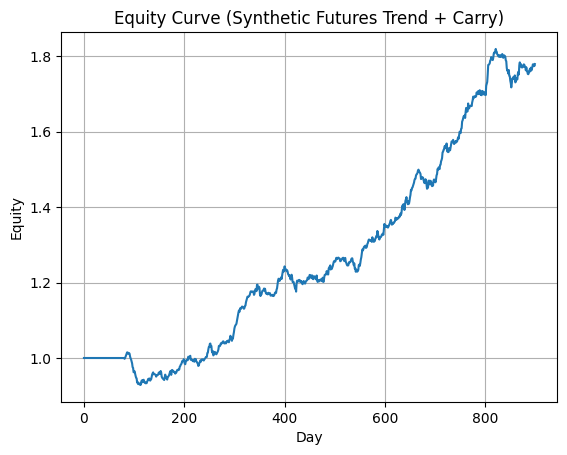

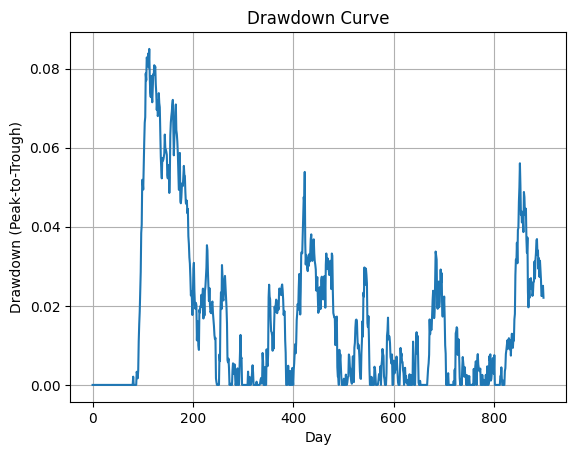

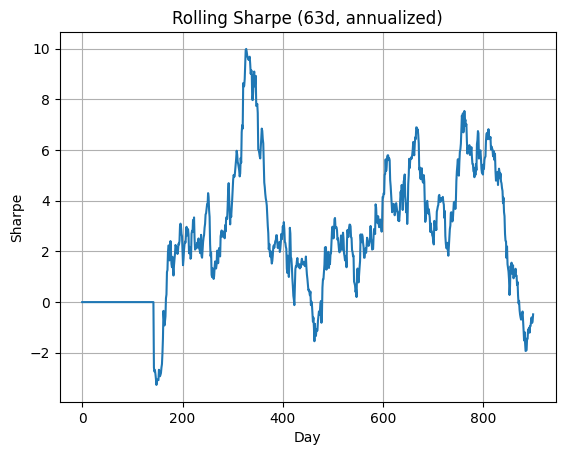

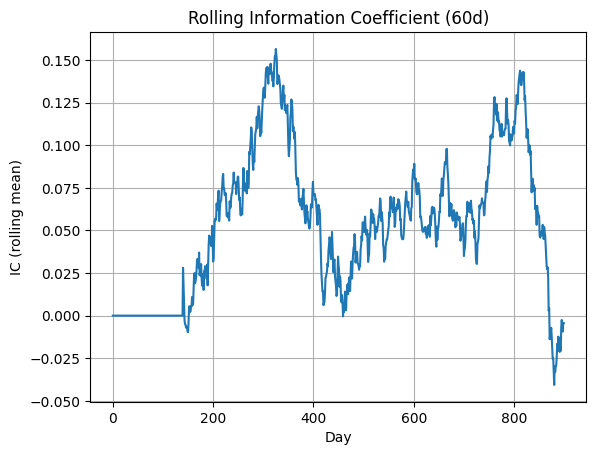

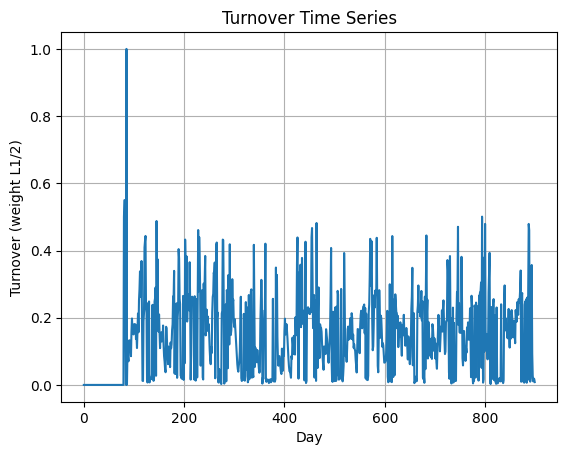

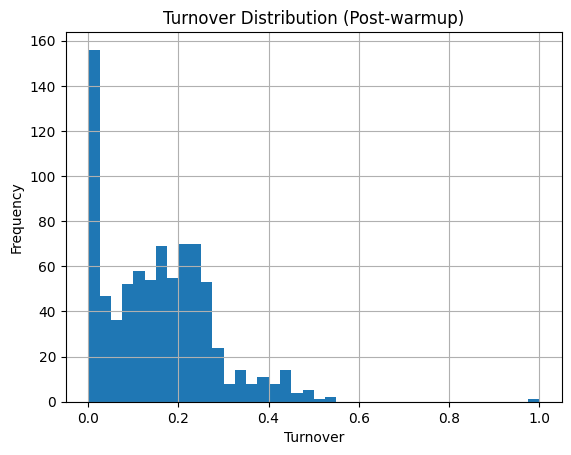

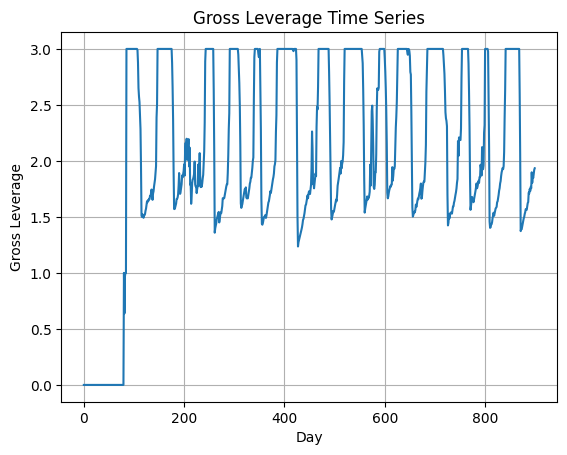

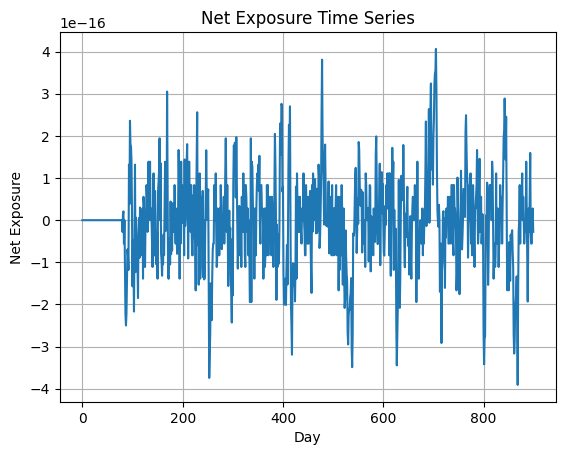

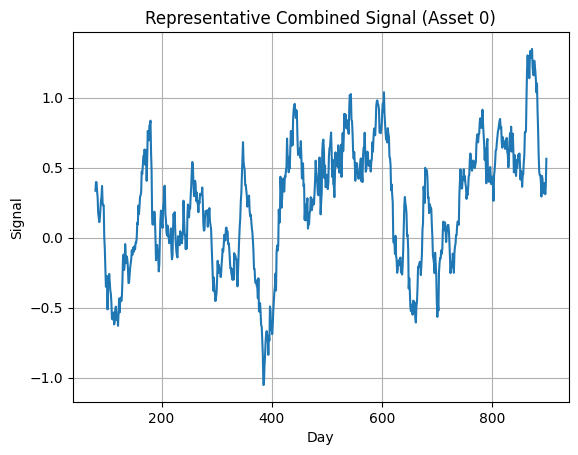

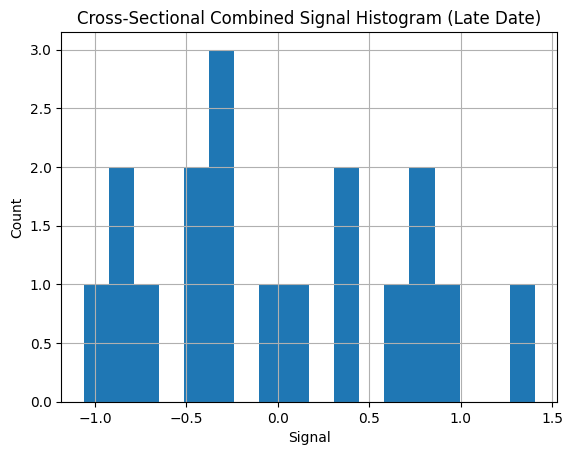

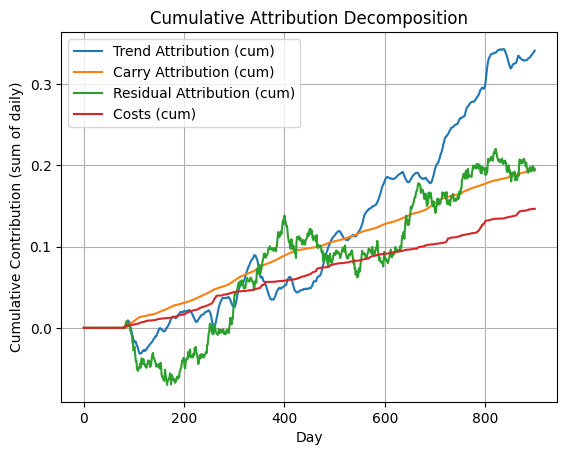

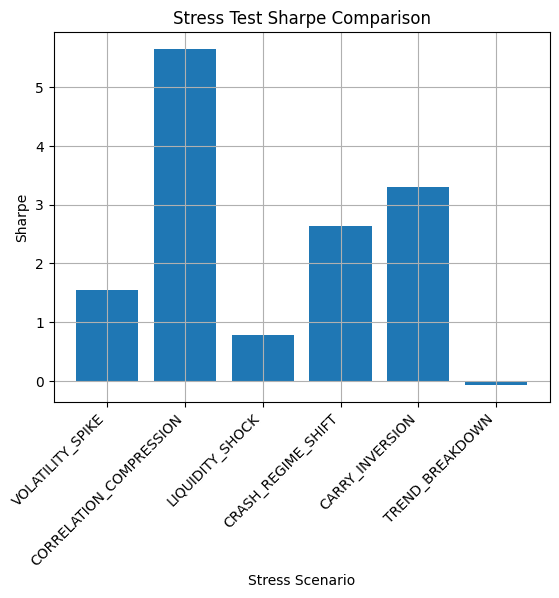

In [10]:

# VISUALIZATION DASHBOARD (Cell 9) — comprehensive, committee-ready matplotlib suite (NO NARRATIVE TEXT)

nD = CONFIG["n_days"]
warm = CONFIG["warmup"]
t_full = list(range(nD))

# Cumulative attribution curves
cum_tr = [0.0] * nD
cum_ca = [0.0] * nD
cum_re = [0.0] * nD
cum_co = [0.0] * nD
for k in range(1, nD):
    cum_tr[k] = cum_tr[k-1] + bt["pnl_trend"][k]
    cum_ca[k] = cum_ca[k-1] + bt["pnl_carry"][k]
    cum_re[k] = cum_re[k-1] + bt["pnl_resid"][k]
    cum_co[k] = cum_co[k-1] + bt["costs"][k]

# Turnover distribution (post-warmup)
turn_post = bt["turnover"][warm:]

# Representative combined signal (Asset 0) — aligned axes
t_sig = list(range(warm, nD))
sig_series = [signals["combo_sig"][0][k] for k in range(warm, nD)]

# Cross-sectional signal histogram at late date
late_t = nD - 2
xs_sig = [signals["combo_sig"][i][late_t] for i in range(CONFIG["n_assets"])]

# Stress Sharpe comparison
stress_labels = list(stress_results.keys())
stress_sh = [stress_results[k]["sharpe"] for k in stress_labels]

# 1) Equity curve
plt.figure()
plt.plot(t_full, bt["equity"])
plt.title("Equity Curve (Synthetic Futures Trend + Carry)")
plt.xlabel("Day")
plt.ylabel("Equity")
plt.grid(True)

# 2) Drawdown curve
plt.figure()
plt.plot(t_full, bt["drawdown"])
plt.title("Drawdown Curve")
plt.xlabel("Day")
plt.ylabel("Drawdown (Peak-to-Trough)")
plt.grid(True)

# 3) Rolling Sharpe
plt.figure()
plt.plot(t_full, bt["roll_sharpe"])
plt.title("Rolling Sharpe (63d, annualized)")
plt.xlabel("Day")
plt.ylabel("Sharpe")
plt.grid(True)

# 4) Rolling IC
plt.figure()
plt.plot(t_full, signals["ic_roll"])
plt.title("Rolling Information Coefficient (60d)")
plt.xlabel("Day")
plt.ylabel("IC (rolling mean)")
plt.grid(True)

# 5) Turnover series
plt.figure()
plt.plot(t_full, bt["turnover"])
plt.title("Turnover Time Series")
plt.xlabel("Day")
plt.ylabel("Turnover (weight L1/2)")
plt.grid(True)

# 6) Turnover histogram
plt.figure()
plt.hist(turn_post, bins=40)
plt.title("Turnover Distribution (Post-warmup)")
plt.xlabel("Turnover")
plt.ylabel("Frequency")
plt.grid(True)

# 7) Gross leverage series
plt.figure()
plt.plot(t_full, bt["gross_lev"])
plt.title("Gross Leverage Time Series")
plt.xlabel("Day")
plt.ylabel("Gross Leverage")
plt.grid(True)

# 8) Net exposure series
plt.figure()
plt.plot(t_full, bt["net_exp"])
plt.title("Net Exposure Time Series")
plt.xlabel("Day")
plt.ylabel("Net Exposure")
plt.grid(True)

# 9) Representative combined signal series (aligned)
plt.figure()
plt.plot(t_sig, sig_series)
plt.title("Representative Combined Signal (Asset 0)")
plt.xlabel("Day")
plt.ylabel("Signal")
plt.grid(True)

# 10) Cross-sectional signal histogram
plt.figure()
plt.hist(xs_sig, bins=max(10, CONFIG["n_assets"]))
plt.title("Cross-Sectional Combined Signal Histogram (Late Date)")
plt.xlabel("Signal")
plt.ylabel("Count")
plt.grid(True)

# 11) Cumulative attribution decomposition
plt.figure()
plt.plot(t_full, cum_tr, label="Trend Attribution (cum)")
plt.plot(t_full, cum_ca, label="Carry Attribution (cum)")
plt.plot(t_full, cum_re, label="Residual Attribution (cum)")
plt.plot(t_full, cum_co, label="Costs (cum)")
plt.title("Cumulative Attribution Decomposition")
plt.xlabel("Day")
plt.ylabel("Cumulative Contribution (sum of daily)")
plt.legend()
plt.grid(True)

# 12) Stress Sharpe comparison
plt.figure()
plt.bar(list(range(len(stress_labels))), stress_sh)
plt.title("Stress Test Sharpe Comparison")
plt.xlabel("Stress Scenario")
plt.ylabel("Sharpe")
plt.xticks(list(range(len(stress_labels))), stress_labels, rotation=45, ha="right")
plt.grid(True)

plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10 — Maximum Audit Bundle (Sensitivity, Monte Carlo, Tamper Evidence, and Packaging)**

**Purpose of the cell**  
Cell 10 completes the research lifecycle by producing the institutional audit bundle. It runs a parameter sensitivity grid over key hyperparameters to reveal whether conclusions are robust or fragile to reasonable tuning changes. It computes a Monte Carlo robustness envelope via block bootstrap of residual components, generating a distribution of terminal equity, Sharpe, and drawdown outcomes across at least 200 simulations. It then writes review checklists, hashes every artifact, constructs a master bundle hash from the artifact registry, and packages all files into a single zip suitable for archival and committee review.

**Parameter sensitivity as surface mapping**  
The sensitivity grid is not optimization; it is a surface map. By varying the short trend lookback and the carry weight, the notebook shows how the blended mechanism changes in responsiveness and in reliance on carry versus trend. Outcomes such as Sharpe, drawdown, and turnover are recorded for each grid point. This is critical because strategies often look stable at a single parameter setting while being highly unstable in neighboring settings. Sensitivity analysis exposes that local fragility.

**Monte Carlo envelope as robustness language**  
The Monte Carlo step treats residual shocks as a stochastic component and resamples them using a block bootstrap, preserving short-horizon dependence. This produces an envelope of possible outcomes under the same structural trend and carry components but different shock realizations. In a mechanism-first frame, this is not a probabilistic forecast of real markets; it is a robustness language for the synthetic model: it tells you whether the policy outcome is dominated by a small set of residual sequences or whether it is stable across perturbations.

**Tamper-evident integrity layer**  
The hashing registry and master bundle hash convert the notebook’s outputs into a defensible audit artifact. If any file is modified, hashes change and the master hash changes. This provides a simple but powerful control against undetected edits and supports litigation-grade reproducibility. The audit index also records determinism certification and governance classification so that the bundle can be evaluated without rerunning the notebook.

**Learning objective**  
The objective is to teach that professional research is not complete until it is packaged, hashed, and reviewable. The audit bundle is the boundary between experimentation and institutional memory: it ensures that what was done can be reconstructed, challenged, and repeated.


###10.2.CODE AND IMPLEMENTATION

In [11]:
# MAXIMUM AUDIT BUNDLE (Cell 10) — sensitivity grid, Monte Carlo envelope, hashing registry, audit index, zip bundle

def run_sensitivity_grid(CONFIG, market):
    results = []
    base_cfg = json.loads(json.dumps(CONFIG))

    # Grid: short trend lookback and carry weight
    for lb in base_cfg["sensitivity"]["trend_lb_short"]:
        for cw in base_cfg["sensitivity"]["carry_weight"]:
            cfg2 = json.loads(json.dumps(base_cfg))
            cfg2["trend_lookbacks"] = [lb, cfg2["trend_lookbacks"][1], cfg2["trend_lookbacks"][2]]
            cfg2["carry_weight"] = cw
            cfg2["trend_weight"] = 1.0 - cw

            # deterministic per grid point
            key = f"LB{lb}_CW{cw:.2f}"
            random.seed(base_cfg["seed"] + int(sha256_bytes((run_id + key).encode("utf-8"))[:8], 16) % 100000)

            # recompute signals + bt
            sig2 = compute_signals(cfg2, market)
            bt2 = backtest_engine(cfg2, market, sig2)
            pnl2 = bt2["pnl"][cfg2["warmup"]:]
            res = {
                "trend_lb_short": lb,
                "carry_weight": cw,
                "trend_weight": 1.0 - cw,
                "terminal_equity": bt2["equity"][-1],
                "sharpe": sharpe(pnl2) if pnl2 else 0.0,
                "max_drawdown": max_drawdown(bt2["equity"]),
                "avg_turnover": mean(bt2["turnover"][cfg2["warmup"]:])
            }
            results.append(res)
    return results

sens = run_sensitivity_grid(CONFIG, market)
sens_art = artifact_template()
sens_art["analysis"] = {"run_id": run_id, "grid": CONFIG["sensitivity"]}
sens_art["outputs"] = {"results": sens}
write_json(os.path.join(DELIV_DIR, "parameter_sensitivity.json"), sens_art)

# Monte Carlo robustness envelope (>=200) via block bootstrap of residual component + regime-consistent vol/liquidity
def block_bootstrap_indices(n, block):
    idx = []
    while len(idx) < n:
        start = random.randint(0, n - 1)
        for k in range(block):
            idx.append((start + k) % n)
            if len(idx) >= n:
                break
    return idx

def monte_carlo_envelope(CONFIG, market, n_sims, block_len):
    nA = CONFIG["n_assets"]
    nD = CONFIG["n_days"]

    # base components
    tr = market["trend_component"]
    ca = market["carry_component"]
    rs = market["resid_component"]

    terminals = []
    sharpes = []
    mdds = []

    for s in range(n_sims):
        # deterministic per sim
        random.seed(CONFIG["seed"] + int(sha256_bytes((run_id + f"MC{s}").encode("utf-8"))[:8], 16) % 100000)

        # bootstrap residual indices
        idx = block_bootstrap_indices(nD, block_len)

        # build new market with bootstrapped residuals
        m2 = dict(market)
        ret2 = [[0.0] * nD for _ in range(nA)]
        rs2 = [[0.0] * nD for _ in range(nA)]

        for i in range(nA):
            for t in range(nD):
                bt_i = idx[t]
                rs2[i][t] = rs[i][bt_i]
                ret2[i][t] = tr[i][t] + ca[i][t] + rs2[i][t]

        m2["resid_component"] = rs2
        m2["ret"] = ret2

        sig2 = compute_signals(CONFIG, m2)
        bt2 = backtest_engine(CONFIG, m2, sig2)
        pnl2 = bt2["pnl"][CONFIG["warmup"]:]
        terminals.append(bt2["equity"][-1])
        sharpes.append(sharpe(pnl2) if pnl2 else 0.0)
        mdds.append(max_drawdown(bt2["equity"]))

    # envelope stats
    terminals_sorted = sorted(terminals)
    sharpes_sorted = sorted(sharpes)
    mdds_sorted = sorted(mdds)

    def pct(xs, p):
        if not xs:
            return 0.0
        k = int(p * (len(xs) - 1))
        return xs[k]

    env = {
        "terminal_equity": {
            "p05": pct(terminals_sorted, 0.05),
            "p50": pct(terminals_sorted, 0.50),
            "p95": pct(terminals_sorted, 0.95),
            "mean": mean(terminals),
            "std": stdev(terminals) if len(terminals) >= 2 else 0.0
        },
        "sharpe": {
            "p05": pct(sharpes_sorted, 0.05),
            "p50": pct(sharpes_sorted, 0.50),
            "p95": pct(sharpes_sorted, 0.95),
            "mean": mean(sharpes),
            "std": stdev(sharpes) if len(sharpes) >= 2 else 0.0
        },
        "max_drawdown": {
            "p05": pct(mdds_sorted, 0.05),
            "p50": pct(mdds_sorted, 0.50),
            "p95": pct(mdds_sorted, 0.95),
            "mean": mean(mdds),
            "std": stdev(mdds) if len(mdds) >= 2 else 0.0
        }
    }
    return env

mc_cfg = CONFIG["monte_carlo"]
mc_env = monte_carlo_envelope(CONFIG, market, mc_cfg["n_sims"], mc_cfg["resid_bootstrap_block"])
mc_art = artifact_template()
mc_art["analysis"] = {"run_id": run_id, "method": "Block bootstrap of residual component", "n_sims": mc_cfg["n_sims"], "block_len": mc_cfg["resid_bootstrap_block"]}
mc_art["outputs"] = mc_env
write_json(os.path.join(DELIV_DIR, "monte_carlo_envelope.json"), mc_art)

# Governance checklist (review-oriented)
chk = artifact_template()
chk["analysis"] = {"run_id": run_id}
chk["outputs"] = {
    "review_checklist": [
        {"item": "Confirm synthetic-only policy acknowledged", "status": "Not verified"},
        {"item": "Verify determinism: seed + config hash + reproducibility report", "status": "Not verified"},
        {"item": "Review execution model assumptions vs intended use", "status": "Not verified"},
        {"item": "Assess stress suite completeness and realism", "status": "Not verified"},
        {"item": "Interpret fragility score and model risk tier conservatively", "status": "Not verified"},
        {"item": "Confirm no external data or APIs used", "status": "Not verified"},
        {"item": "Independent replication run recommended", "status": "Not verified"}
    ]
}
write_json(os.path.join(DELIV_DIR, "review_checklist.json"), chk)

# Artifact hashing registry + audit index
# Required: hash every artifact, compute master_bundle_hash, record in audit_index.json
artifact_paths = []
# root files
for f in ROOT_FILES:
    if os.path.exists(f):
        artifact_paths.append(f)

# deliverables
for name in os.listdir(DELIV_DIR):
    p = os.path.join(DELIV_DIR, name)
    if os.path.isfile(p) and name.endswith(".json"):
        artifact_paths.append(p)

artifact_hashes = {}
for p in sorted(artifact_paths):
    artifact_hashes[p] = {"sha256": sha256_file(p)}

hash_reg = artifact_template()
hash_reg["analysis"] = {"run_id": run_id, "hash_alg": "sha256", "n_artifacts": len(artifact_hashes)}
hash_reg["outputs"] = {"artifacts": artifact_hashes}
write_json(os.path.join(DELIV_DIR, "artifact_hash_registry.json"), hash_reg)

# Audit index with master bundle hash over concatenated individual hashes (tamper-evident)
concat = "".join([artifact_hashes[p]["sha256"] for p in sorted(artifact_hashes.keys())])
master_bundle_hash = sha256_bytes(concat.encode("utf-8"))

audit_index = artifact_template()
audit_index["analysis"] = {
    "run_id": run_id,
    "config_hash_sha256": config_hash,
    "master_bundle_hash_sha256": master_bundle_hash,
    "artifact_count": len(artifact_hashes),
    "utc_timestamp": utc_now_iso()
}
audit_index["outputs"] = {
    "root_files": ROOT_FILES,
    "deliverables_dir": DELIV_DIR,
    "determinism_ok": json.load(open(os.path.join(DELIV_DIR, "reproducibility_report.json"), "r", encoding="utf-8"))["outputs"]["determinism_ok"],
    "model_risk_tier": json.load(open(os.path.join(DELIV_DIR, "model_risk_score.json"), "r", encoding="utf-8"))["outputs"]["model_risk_tier"],
    "deployment_status": json.load(open(os.path.join(DELIV_DIR, "deployment_status.json"), "r", encoding="utf-8"))["outputs"]["deployment_status"]
}
write_json(os.path.join(DELIV_DIR, "audit_index.json"), audit_index)

# Additional required artifacts (placeholders with correct schema and concrete outputs where applicable)
gov_maturity = json.load(open(os.path.join(DELIV_DIR, "governance_maturity.json"), "r", encoding="utf-8"))
dep_status = json.load(open(os.path.join(DELIV_DIR, "deployment_status.json"), "r", encoding="utf-8"))

# Ensure required named artifacts exist (already created in earlier cells; enforce presence)
required_names = [
    "metrics_summary.json",
    "diagnostics.json",
    "equity_curve.json",
    "positions.json",
    "stress_test_results.json",
    "parameter_sensitivity.json",
    "monte_carlo_envelope.json",
    "fragility_analysis.json",
    "model_risk_score.json",
    "governance_maturity.json",
    "deployment_status.json",
    "signal_matrix.json",
    "execution_audit.json",
    "reproducibility_report.json",
    "artifact_hash_registry.json",
    "audit_index.json",
    "review_checklist.json"
]
missing = [x for x in required_names if not os.path.exists(os.path.join(DELIV_DIR, x))]
if missing:
    # Create empty-but-valid placeholders (should be rare)
    for fn in missing:
        ph = artifact_template()
        ph["analysis"] = {"run_id": run_id, "note": "Auto-created placeholder due to missing artifact in pipeline"}
        write_json(os.path.join(DELIV_DIR, fn), ph)

# Zip bundle
bundle_name = "lab_bundle.zip"
with zipfile.ZipFile(bundle_name, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for f in ROOT_FILES:
        if os.path.exists(f):
            z.write(f, arcname=f)
    for root, _, files in os.walk(DELIV_DIR):
        for fn in files:
            path = os.path.join(root, fn)
            arc = os.path.relpath(path, ".")
            z.write(path, arcname=arc)

print("Audit bundle created:", bundle_name)
print("Master bundle hash (sha256 over artifact-hash concat):", master_bundle_hash)


Audit bundle created: lab_bundle.zip
Master bundle hash (sha256 over artifact-hash concat): 4f279d6d134412ba09fbfd2b8314abdb5bc4bbeadeea54d277f7fb5d8b7802e0


##11.CONCLUSION


**Conclusion — Structural Lessons from a Futures Trend + Carry Laboratory**

**What was learned: strategy equals mechanism plus constraint**  
The central lesson is that a “strategy” is not a ranking rule; it is a mechanism embedded in a constrained execution system. Trend and carry are interpretable sources of return in a futures context because they correspond to distinct economic objects: persistence in price dynamics and premia embedded in the forward curve. But the policy that attempts to harvest them must survive liquidity variation, regime shifts, and cost convexity. In practice, the observed equity curve is the outcome of an interaction between signals, controls, and frictions. This notebook makes that interaction explicit by decomposing returns into trend, carry, and residual contributions while separately accounting for costs. That decomposition is not merely an explanatory convenience; it is a diagnostic tool for answering the most important governance question: what is this system actually doing?

**Carry, regime, and surface behavior: when signals flip meaning**  
In a mechanism-first frame, carry is not a “feature” but a state-dependent incentive. When carry is positive and stable, it can anchor the portfolio’s return stream even when trends are modest. When carry inverts, it can become a persistent headwind that a trend overlay may or may not overcome depending on dispersion and turnover constraints. The stress tests that invert carry are not performance games; they are hypothesis attacks: they ask whether the system is implicitly relying on a structural assumption that carry is a positive drift. Similarly, trend breakdown is a direct assault on the assumption of persistence. In choppy environments, the trend signal may still produce rankings, but the ranking may be dominated by noise and the rebalancing required to express it becomes costly. The surfaces that matter here are not abstract: the cost surface and the feasibility surface determine whether the policy can translate a score into an implementable position.

**Fragility modes: how the system fails**  
Several fragility modes emerge naturally. One is **dispersion dependence**: when cross-sectional dispersion collapses (as in correlation compression), ranking becomes unstable and the portfolio can become an expensive bet on a small set of noisy differences. Another is **turnover fragility**: if the combined score changes rapidly, turnover rises, and convex impact can dominate gross edge. A third is **liquidity-gated failure**: in crash-like states, liquidity impairment makes trading expensive precisely when signals may flip or when risk controls force de-risking. A fourth is **risk-gate whipsaw**: drawdown and volatility gates can protect against ruin, but if gates trigger and release repeatedly in a choppy regime, the portfolio can realize costs without maintaining exposure long enough for the mechanism to express itself. These failure modes are not bugs in code; they are structural consequences of interacting constraints.

**Why execution dominates theory**  
The notebook’s execution model is intentionally designed to make a simple point: in futures portfolios, especially those that rebalance frequently, the difference between a theoretical allocation and an implementable allocation is not a rounding error. When costs scale with turnover and liquidity and include a convex term, the marginal cost of responsiveness increases nonlinearly. This is why professional intuition places so much emphasis on liquidity, rebalancing frequency, and capacity. The correct question becomes: what is the maximum aggressiveness that remains inside a stable cost regime? This is not answered by maximizing Sharpe in a single run. It is answered by mapping the surface: sensitivity grids, stress reruns, and Monte Carlo envelopes that reveal whether performance collapses when the world is slightly different.

**How to iterate experimentally: causal probes, not optimization**  
The notebook should be used as a controlled experimental environment. If you want to probe trend dependence, vary the trend lookbacks and weights while holding carry fixed, and watch how turnover and the cost decomposition evolve. If you want to probe carry reliance, invert carry, compress carry dispersion, or increase carry variance by asset class. If you want to locate capacity cliffs, increase the impact exponent or reduce liquidity levels, then examine how realized costs scale with turnover. If you want to stress cross-sectional differentiation, increase correlation and reduce residual dispersion. The point of these experiments is not to “find better parameters,” but to reveal which assumptions are load-bearing. A strategy is governable when the load-bearing assumptions are known, testable, and monitored.

**Governance implications: classification and discipline**  
The governance engine in this notebook produces a fragility score and assigns a model risk tier. These are not certifications of quality; they are classification devices that enforce conservative behavior. A high fragility score should not be interpreted as “bad”; it should be interpreted as “sensitive,” which demands stronger controls, more stress coverage, and tighter deployment permissions. A low fragility score in a synthetic world does not justify deployment; it indicates that within the constructed environment, the policy’s behavior degrades gradually rather than catastrophically under the tested perturbations. The only defensible operational posture is to treat this system as a research laboratory unless and until external validation, independent replication, and human committee review are complete.

**Final reinforcement: mechanism-first professional intuition**  
This laboratory trains the practitioner to see strategies as economic mechanisms expressed through constrained actions. Trend is not a magic predictor; it is a bet on persistence. Carry is not free yield; it is compensation for bearing state-dependent risk. Execution is not an implementation detail; it is the channel through which theoretical edge becomes realized return or evaporates as impact. Regimes are not labels; they are structural states that change volatility, correlation, and liquidity simultaneously. If you internalize these mechanics, you will be able to reason about real portfolios with greater clarity: not by forecasting, but by understanding which surfaces you are standing on and how quickly they can tilt beneath your feet.
